In [1]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(
    tf.config.list_physical_devices('GPU')[0], True)
print(tf.__version__)
print("Usage of gpu: {}".format(tf.config.list_physical_devices()))
print("Built with CUDA: {}".format(tf.test.is_built_with_cuda()))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Init Plugin
2.5.0Init Graph Optimizer
Init Kernel

Usage of gpu: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: False
Num GPUs Available:  1


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
import tensorflow.keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from sklearn.model_selection import KFold 
import pydot
import gc
import pickle


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.5.0


In [3]:
base_dir = "/Users/tarun/IIITN Project/ADNI/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"
save_dir = root_dir + "saved_models/"

In [4]:
IMG_SIZE = 256
IMAGE_SIZE = [256, 256]
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [5]:
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=work_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 2614 images belonging to 5 classes.


In [6]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)
#Performing over-sampling of the data, since the classes are imbalanced
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(2614, 256, 256, 3) (2614, 5)
(5800, 256, 256, 3) (5800, 5)


In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

(4640, 256, 256, 3) (1160, 256, 256, 3) (4640, 5) (1160, 5)


In [8]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(32, 3, activation=act, padding='same'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(64, 3, activation=act, padding='same'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(128, 3, activation=act, padding='same'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(256, 3, activation=act, padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(5, activation='softmax')        
    ], name = "cnn_model")

    return model

In [9]:
# VALIDATION_ACCURACY = []
# VALIDAITON_LOSS = []
# EPOCHS = 100
# batch_size = 32
# idg = IDG()
# # k = 20
# # kf = KFold(n_splits=k, random_state=None)
# fold_var = 1

# # for train_index, val_index in kf.split(train_data, train_labels):
# X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
# #     X_train, X_test = train_data[train_index, :], train_data[val_index, :]
# #     y_train, y_test = train_labels[train_index], train_labels[val_index]
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# train_gen = idg.flow(X_train, y_train, batch_size=32, shuffle=True )
# val_gen = idg.flow(X_test, y_test, batch_size=8, shuffle=True)



# model = construct_model()
# model.summary()

# METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
#            tf.keras.metrics.AUC(name='auc'),
#            tfa.metrics.F1Score(num_classes=5)]

# model.compile(optimizer='adam',
#               loss=tf.losses.CategoricalCrossentropy(),
#               metrics=METRICS)

# def get_model_name(k):
#     return 'model_'+str(k)+'.h5'

# checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var),
#                                                 monitor='val_acc', verbose=1,
#                                                 save_best_only=True, mode='max')

# my_callback = checkpoint
# CALLBACKS = [my_callback]
# # EarlyStopping callback to make sure model is always learning
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [10]:
# history = model.fit(train_gen,
#                    steps_per_epoch = int(3712 // batch_size),
#                    epochs = EPOCHS,
#                    verbose = 1,
#                    validation_data = val_gen,
#                    validation_steps = int(928 // batch_size),
#                    callbacks = CALLBACKS
#                    )

# model.load_weights("/saved_models/model_"+str(fold_var)+".h5")

# results = model.evaluate(val_gen)
# results = dict(zip(model.metrics_names, results))

# VALIDATION_ACCURACY.append(results['accuracy'])
# VALIDATION_LOSS.append(results['loss'])

# tf.keras.backend.clear_session()

In [11]:
# With K-Fold
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
EPOCHS = 100
batch_size = 32
idg = IDG()
k = 20
kf = KFold(n_splits=k, random_state=None)
fold_var = 1

for train_index, val_index in kf.split(train_data, train_labels):
    # X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
#     X_train, X_test = train_data[train_index, :], train_data[val_index, :]
#     y_train, y_test = train_labels[train_index], train_labels[val_index]
#     print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    train_gen = idg.flow(train_data[train_index, :], train_labels[train_index], batch_size=32, shuffle=True )
    val_gen = idg.flow(train_data[val_index, :], train_labels[val_index], batch_size=8, shuffle=True)



    model = construct_model()
    model.summary()

    METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
               tf.keras.metrics.AUC(name='auc'),
               tfa.metrics.F1Score(num_classes=5)]

    model.compile(optimizer='adam',
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=METRICS)

    def get_model_name(k):
        return 'model_'+str(k)+'.h5'

    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var),
                                                    monitor='val_acc', verbose=1,
                                                    save_best_only=True, mode='max')

    my_callback = checkpoint
    CALLBACKS = [my_callback]
    # EarlyStopping callback to make sure model is always learning
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)

#     del train_data
#     del test_data

    history = model.fit(train_gen,
                       steps_per_epoch = int(3712 // batch_size),
                       epochs = EPOCHS,
                       verbose = 1,
                       validation_data = val_gen,
                       validation_steps = int(928 // batch_size),
                       callbacks = CALLBACKS
                       )
    
#     fig, ax = plt.subplots(3, 1, figsize = (20, 20))
#     ax = ax.ravel()

#     for i, metric in enumerate(["acc", "auc", "loss"]):
#         ax[i].plot(history.history[metric])
#         ax[i].plot(history.history["val_" + metric])
#         ax[i].set_title("Model {}".format(metric))
#         ax[i].set_xlabel("Epochs")
#         ax[i].set_ylabel(metric)
#         ax[i].legend(["train", "val"])
        
    with open(save_dir + "history_"+str(fold_var), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    results = model.evaluate(val_gen)
    results = dict(zip(model.metrics_names, results))

    VALIDATION_ACCURACY.append(results['acc'])
    VALIDAITON_LOSS.append(results['loss'])

    del model
    del history
    gc.collect()
    tf.keras.backend.clear_session()

    fold_var += 1

Metal device set to: Apple M1


2022-02-28 12:38:35.769585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-28 12:38:35.771770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        12

2022-02-28 12:38:36.395123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-28 12:38:36.396499: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
 13/116 [==>...........................] - ETA: 26s - loss: 2.3566 - acc: 0.1923 - auc: 0.5005 - f1_score: 0.1838

2022-02-28 12:38:37.210517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.9029 - acc: 0.2168 - auc: 0.5266 - f1_score: 0.2170

2022-02-28 12:39:08.911031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 33s 273ms/step - loss: 1.9029 - acc: 0.2168 - auc: 0.5266 - f1_score: 0.2170 - val_loss: 3.1002 - val_acc: 0.2155 - val_auc: 0.5022 - val_f1_score: 0.0709

Epoch 00001: val_acc improved from -inf to 0.21552, saving model to ./saved_models/model_1.h5
Epoch 2/100
116/116 [==============================] - 29s 251ms/step - loss: 1.6757 - acc: 0.2484 - auc: 0.5513 - f1_score: 0.2472 - val_loss: 1.8233 - val_acc: 0.1810 - val_auc: 0.4825 - val_f1_score: 0.1064

Epoch 00002: val_acc did not improve from 0.21552
Epoch 3/100
116/116 [==============================] - 30s 260ms/step - loss: 1.6240 - acc: 0.2465 - auc: 0.5652 - f1_score: 0.2433 - val_loss: 1.7984 - val_acc: 0.1595 - val_auc: 0.4878 - val_f1_score: 0.0552

Epoch 00003: val_acc did not improve from 0.21552
Epoch 4/100
116/116 [==============================] - 27s 233ms/step - loss: 1.5988 - acc: 0.2600 - auc: 0.5841 - f1_score: 0.2560 - val_loss: 1.7548 - val_acc: 0.1638 - val_auc: 0.506

116/116 [==============================] - 27s 235ms/step - loss: 0.1466 - acc: 0.9479 - auc: 0.9964 - f1_score: 0.9478 - val_loss: 0.3784 - val_acc: 0.8750 - val_auc: 0.9792 - val_f1_score: 0.8668

Epoch 00059: val_acc did not improve from 0.91810
Epoch 60/100
116/116 [==============================] - 27s 235ms/step - loss: 0.1037 - acc: 0.9673 - auc: 0.9978 - f1_score: 0.9670 - val_loss: 0.4430 - val_acc: 0.8578 - val_auc: 0.9741 - val_f1_score: 0.8568

Epoch 00060: val_acc did not improve from 0.91810
Epoch 61/100
116/116 [==============================] - 27s 229ms/step - loss: 0.0734 - acc: 0.9757 - auc: 0.9993 - f1_score: 0.9755 - val_loss: 0.3385 - val_acc: 0.9009 - val_auc: 0.9793 - val_f1_score: 0.8986

Epoch 00061: val_acc did not improve from 0.91810
Epoch 62/100
116/116 [==============================] - 27s 228ms/step - loss: 0.0775 - acc: 0.9749 - auc: 0.9985 - f1_score: 0.9747 - val_loss: 0.2823 - val_acc: 0.9095 - val_auc: 0.9894 - val_f1_score: 0.9047

Epoch 00062: va


Epoch 00089: val_acc did not improve from 0.94828
Epoch 90/100
116/116 [==============================] - 26s 227ms/step - loss: 0.0408 - acc: 0.9871 - auc: 0.9994 - f1_score: 0.9870 - val_loss: 0.5922 - val_acc: 0.8448 - val_auc: 0.9601 - val_f1_score: 0.8460

Epoch 00090: val_acc did not improve from 0.94828
Epoch 91/100
116/116 [==============================] - 26s 228ms/step - loss: 0.0384 - acc: 0.9873 - auc: 0.9995 - f1_score: 0.9872 - val_loss: 0.3267 - val_acc: 0.9095 - val_auc: 0.9821 - val_f1_score: 0.9055

Epoch 00091: val_acc did not improve from 0.94828
Epoch 92/100
116/116 [==============================] - 26s 228ms/step - loss: 0.0428 - acc: 0.9846 - auc: 0.9993 - f1_score: 0.9846 - val_loss: 0.2411 - val_acc: 0.9267 - val_auc: 0.9901 - val_f1_score: 0.9216

Epoch 00092: val_acc did not improve from 0.94828
Epoch 93/100
116/116 [==============================] - 26s 228ms/step - loss: 0.0510 - acc: 0.9833 - auc: 0.9989 - f1_score: 0.9833 - val_loss: 0.2801 - val_acc: 

2022-02-28 13:24:05.207133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8870 - acc: 0.2208 - auc: 0.5224 - f1_score: 0.2205

2022-02-28 13:24:32.287895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 28s 236ms/step - loss: 1.8870 - acc: 0.2208 - auc: 0.5224 - f1_score: 0.2205 - val_loss: 1.6099 - val_acc: 0.2328 - val_auc: 0.5566 - val_f1_score: 0.0996

Epoch 00001: val_acc improved from -inf to 0.23276, saving model to ./saved_models/model_2.h5
Epoch 2/100
116/116 [==============================] - 27s 235ms/step - loss: 1.6897 - acc: 0.2354 - auc: 0.5391 - f1_score: 0.2340 - val_loss: 1.6593 - val_acc: 0.2457 - val_auc: 0.5121 - val_f1_score: 0.1096

Epoch 00002: val_acc improved from 0.23276 to 0.24569, saving model to ./saved_models/model_2.h5
Epoch 3/100
116/116 [==============================] - 27s 237ms/step - loss: 1.6337 - acc: 0.2443 - auc: 0.5589 - f1_score: 0.2428 - val_loss: 1.7072 - val_acc: 0.2069 - val_auc: 0.4974 - val_f1_score: 0.0963

Epoch 00003: val_acc did not improve from 0.24569
Epoch 4/100
116/116 [==============================] - 27s 236ms/step - loss: 1.6072 - acc: 0.2719 - auc: 0.5835 - f1_score: 0.2693 - val_

116/116 [==============================] - 29s 248ms/step - loss: 0.8282 - acc: 0.6685 - auc: 0.9130 - f1_score: 0.6674 - val_loss: 1.2806 - val_acc: 0.4871 - val_auc: 0.7916 - val_f1_score: 0.4090

Epoch 00031: val_acc did not improve from 0.60776
Epoch 32/100
116/116 [==============================] - 29s 251ms/step - loss: 0.8107 - acc: 0.6879 - auc: 0.9166 - f1_score: 0.6881 - val_loss: 0.7974 - val_acc: 0.6983 - val_auc: 0.9272 - val_f1_score: 0.6860

Epoch 00032: val_acc improved from 0.60776 to 0.69828, saving model to ./saved_models/model_2.h5
Epoch 33/100
116/116 [==============================] - 29s 247ms/step - loss: 0.7013 - acc: 0.7260 - auc: 0.9380 - f1_score: 0.7257 - val_loss: 0.9881 - val_acc: 0.6207 - val_auc: 0.8777 - val_f1_score: 0.5933

Epoch 00033: val_acc did not improve from 0.69828
Epoch 34/100
116/116 [==============================] - 29s 252ms/step - loss: 0.8845 - acc: 0.6574 - auc: 0.9019 - f1_score: 0.6578 - val_loss: 0.8350 - val_acc: 0.6810 - val_auc:


Epoch 00091: val_acc did not improve from 0.92241
Epoch 92/100
116/116 [==============================] - 28s 243ms/step - loss: 0.0559 - acc: 0.9819 - auc: 0.9994 - f1_score: 0.9819 - val_loss: 0.1960 - val_acc: 0.9397 - val_auc: 0.9930 - val_f1_score: 0.9391

Epoch 00092: val_acc improved from 0.92241 to 0.93966, saving model to ./saved_models/model_2.h5
Epoch 93/100
116/116 [==============================] - 27s 237ms/step - loss: 0.0426 - acc: 0.9865 - auc: 0.9994 - f1_score: 0.9865 - val_loss: 0.2801 - val_acc: 0.9181 - val_auc: 0.9885 - val_f1_score: 0.9205

Epoch 00093: val_acc did not improve from 0.93966
Epoch 94/100
116/116 [==============================] - 28s 245ms/step - loss: 0.0338 - acc: 0.9897 - auc: 0.9997 - f1_score: 0.9897 - val_loss: 0.1703 - val_acc: 0.9483 - val_auc: 0.9958 - val_f1_score: 0.9482

Epoch 00094: val_acc improved from 0.93966 to 0.94828, saving model to ./saved_models/model_2.h5
Epoch 95/100
116/116 [==============================] - 28s 237ms/ste

2022-02-28 14:10:10.190479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8371 - acc: 0.2193 - auc: 0.5306 - f1_score: 0.2188

2022-02-28 14:10:38.584204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 30s 249ms/step - loss: 1.8371 - acc: 0.2193 - auc: 0.5306 - f1_score: 0.2188 - val_loss: 1.6047 - val_acc: 0.2543 - val_auc: 0.5626 - val_f1_score: 0.2030

Epoch 00001: val_acc improved from -inf to 0.25431, saving model to ./saved_models/model_3.h5
Epoch 2/100
116/116 [==============================] - 28s 240ms/step - loss: 1.6784 - acc: 0.2227 - auc: 0.5290 - f1_score: 0.2226 - val_loss: 1.6164 - val_acc: 0.2112 - val_auc: 0.5345 - val_f1_score: 0.1237

Epoch 00002: val_acc did not improve from 0.25431
Epoch 3/100
116/116 [==============================] - 28s 238ms/step - loss: 1.6255 - acc: 0.2527 - auc: 0.5588 - f1_score: 0.2504 - val_loss: 1.6318 - val_acc: 0.1767 - val_auc: 0.5078 - val_f1_score: 0.1291

Epoch 00003: val_acc did not improve from 0.25431
Epoch 4/100
116/116 [==============================] - 28s 239ms/step - loss: 1.6056 - acc: 0.2659 - auc: 0.5822 - f1_score: 0.2638 - val_loss: 1.6127 - val_acc: 0.2198 - val_auc: 0.553

116/116 [==============================] - 27s 232ms/step - loss: 0.4130 - acc: 0.8461 - auc: 0.9783 - f1_score: 0.8452 - val_loss: 0.6189 - val_acc: 0.7672 - val_auc: 0.9530 - val_f1_score: 0.7752

Epoch 00031: val_acc improved from 0.73707 to 0.76724, saving model to ./saved_models/model_3.h5
Epoch 32/100
116/116 [==============================] - 27s 235ms/step - loss: 0.3986 - acc: 0.8553 - auc: 0.9788 - f1_score: 0.8541 - val_loss: 0.6244 - val_acc: 0.7759 - val_auc: 0.9507 - val_f1_score: 0.7879

Epoch 00032: val_acc improved from 0.76724 to 0.77586, saving model to ./saved_models/model_3.h5
Epoch 33/100
116/116 [==============================] - 27s 234ms/step - loss: 0.3608 - acc: 0.8696 - auc: 0.9827 - f1_score: 0.8690 - val_loss: 0.9340 - val_acc: 0.6207 - val_auc: 0.9021 - val_f1_score: 0.6040

Epoch 00033: val_acc did not improve from 0.77586
Epoch 34/100
116/116 [==============================] - 27s 236ms/step - loss: 0.3835 - acc: 0.8653 - auc: 0.9797 - f1_score: 0.8649 

116/116 [==============================] - 27s 236ms/step - loss: 0.0490 - acc: 0.9843 - auc: 0.9994 - f1_score: 0.9842 - val_loss: 0.2318 - val_acc: 0.9095 - val_auc: 0.9940 - val_f1_score: 0.9104

Epoch 00061: val_acc did not improve from 0.92672
Epoch 62/100
116/116 [==============================] - 27s 233ms/step - loss: 0.0581 - acc: 0.9806 - auc: 0.9991 - f1_score: 0.9806 - val_loss: 0.3154 - val_acc: 0.8922 - val_auc: 0.9873 - val_f1_score: 0.8931

Epoch 00062: val_acc did not improve from 0.92672
Epoch 63/100
116/116 [==============================] - 30s 259ms/step - loss: 0.0649 - acc: 0.9779 - auc: 0.9989 - f1_score: 0.9779 - val_loss: 0.2894 - val_acc: 0.9267 - val_auc: 0.9876 - val_f1_score: 0.9271

Epoch 00063: val_acc did not improve from 0.92672
Epoch 64/100
116/116 [==============================] - 28s 243ms/step - loss: 0.1555 - acc: 0.9511 - auc: 0.9954 - f1_score: 0.9511 - val_loss: 0.5319 - val_acc: 0.7931 - val_auc: 0.9630 - val_f1_score: 0.8020

Epoch 00064: va

116/116 [==============================] - 27s 230ms/step - loss: 0.0483 - acc: 0.9865 - auc: 0.9989 - f1_score: 0.9865 - val_loss: 0.2779 - val_acc: 0.9310 - val_auc: 0.9856 - val_f1_score: 0.9288

Epoch 00092: val_acc did not improve from 0.94397
Epoch 93/100
116/116 [==============================] - 27s 233ms/step - loss: 0.0397 - acc: 0.9884 - auc: 0.9990 - f1_score: 0.9884 - val_loss: 0.2983 - val_acc: 0.9138 - val_auc: 0.9848 - val_f1_score: 0.9154

Epoch 00093: val_acc did not improve from 0.94397
Epoch 94/100
116/116 [==============================] - 27s 231ms/step - loss: 0.0391 - acc: 0.9865 - auc: 0.9996 - f1_score: 0.9864 - val_loss: 0.4090 - val_acc: 0.8793 - val_auc: 0.9794 - val_f1_score: 0.8768

Epoch 00094: val_acc did not improve from 0.94397
Epoch 95/100
116/116 [==============================] - 27s 231ms/step - loss: 0.0443 - acc: 0.9835 - auc: 0.9995 - f1_score: 0.9835 - val_loss: 0.2195 - val_acc: 0.9267 - val_auc: 0.9947 - val_f1_score: 0.9278

Epoch 00095: va

2022-02-28 14:55:52.572551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8792 - acc: 0.2163 - auc: 0.5281 - f1_score: 0.2148

2022-02-28 14:56:19.884895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 28s 237ms/step - loss: 1.8792 - acc: 0.2163 - auc: 0.5281 - f1_score: 0.2148 - val_loss: 1.8645 - val_acc: 0.1983 - val_auc: 0.4874 - val_f1_score: 0.1127

Epoch 00001: val_acc improved from -inf to 0.19828, saving model to ./saved_models/model_4.h5
Epoch 2/100
116/116 [==============================] - 27s 233ms/step - loss: 1.6697 - acc: 0.2497 - auc: 0.5513 - f1_score: 0.2486 - val_loss: 1.6965 - val_acc: 0.1853 - val_auc: 0.4674 - val_f1_score: 0.0625

Epoch 00002: val_acc did not improve from 0.19828
Epoch 3/100
116/116 [==============================] - 27s 232ms/step - loss: 1.6298 - acc: 0.2559 - auc: 0.5697 - f1_score: 0.2556 - val_loss: 1.8645 - val_acc: 0.1983 - val_auc: 0.4860 - val_f1_score: 0.1140

Epoch 00003: val_acc did not improve from 0.19828
Epoch 4/100
116/116 [==============================] - 27s 234ms/step - loss: 1.6023 - acc: 0.2827 - auc: 0.5893 - f1_score: 0.2797 - val_loss: 5.8981 - val_acc: 0.1853 - val_auc: 0.495


Epoch 00060: val_acc did not improve from 0.89655
Epoch 61/100
116/116 [==============================] - 27s 233ms/step - loss: 0.1018 - acc: 0.9646 - auc: 0.9983 - f1_score: 0.9645 - val_loss: 0.3798 - val_acc: 0.8750 - val_auc: 0.9773 - val_f1_score: 0.8758

Epoch 00061: val_acc did not improve from 0.89655
Epoch 62/100
116/116 [==============================] - 27s 232ms/step - loss: 0.0958 - acc: 0.9657 - auc: 0.9983 - f1_score: 0.9656 - val_loss: 0.4635 - val_acc: 0.8836 - val_auc: 0.9703 - val_f1_score: 0.8857

Epoch 00062: val_acc did not improve from 0.89655
Epoch 63/100
116/116 [==============================] - 27s 234ms/step - loss: 0.1193 - acc: 0.9568 - auc: 0.9971 - f1_score: 0.9569 - val_loss: 0.3772 - val_acc: 0.8922 - val_auc: 0.9746 - val_f1_score: 0.8946

Epoch 00063: val_acc did not improve from 0.89655
Epoch 64/100
116/116 [==============================] - 27s 235ms/step - loss: 0.0820 - acc: 0.9725 - auc: 0.9984 - f1_score: 0.9724 - val_loss: 0.3064 - val_acc: 


Epoch 00091: val_acc did not improve from 0.92241
Epoch 92/100
116/116 [==============================] - 27s 236ms/step - loss: 0.0440 - acc: 0.9841 - auc: 0.9993 - f1_score: 0.9840 - val_loss: 0.3239 - val_acc: 0.9052 - val_auc: 0.9847 - val_f1_score: 0.9025

Epoch 00092: val_acc did not improve from 0.92241
Epoch 93/100
116/116 [==============================] - 30s 259ms/step - loss: 0.0354 - acc: 0.9873 - auc: 0.9997 - f1_score: 0.9873 - val_loss: 0.3299 - val_acc: 0.9052 - val_auc: 0.9824 - val_f1_score: 0.9032

Epoch 00093: val_acc did not improve from 0.92241
Epoch 94/100
116/116 [==============================] - 27s 232ms/step - loss: 0.0345 - acc: 0.9892 - auc: 0.9997 - f1_score: 0.9892 - val_loss: 0.3270 - val_acc: 0.8966 - val_auc: 0.9864 - val_f1_score: 0.8977

Epoch 00094: val_acc did not improve from 0.92241
Epoch 95/100
116/116 [==============================] - 27s 234ms/step - loss: 0.0468 - acc: 0.9849 - auc: 0.9992 - f1_score: 0.9849 - val_loss: 0.3246 - val_acc: 

2022-02-28 15:41:19.638152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8512 - acc: 0.2181 - auc: 0.5159 - f1_score: 0.2177

2022-02-28 15:41:46.813763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 28s 236ms/step - loss: 1.8512 - acc: 0.2181 - auc: 0.5159 - f1_score: 0.2177 - val_loss: 1.6644 - val_acc: 0.2026 - val_auc: 0.4997 - val_f1_score: 0.1099

Epoch 00001: val_acc improved from -inf to 0.20259, saving model to ./saved_models/model_5.h5
Epoch 2/100
116/116 [==============================] - 27s 231ms/step - loss: 1.6784 - acc: 0.2338 - auc: 0.5381 - f1_score: 0.2326 - val_loss: 1.7249 - val_acc: 0.2026 - val_auc: 0.5017 - val_f1_score: 0.0674

Epoch 00002: val_acc did not improve from 0.20259
Epoch 3/100
116/116 [==============================] - 27s 233ms/step - loss: 1.6356 - acc: 0.2578 - auc: 0.5657 - f1_score: 0.2544 - val_loss: 1.7422 - val_acc: 0.1940 - val_auc: 0.4895 - val_f1_score: 0.0721

Epoch 00003: val_acc did not improve from 0.20259
Epoch 4/100
116/116 [==============================] - 27s 232ms/step - loss: 1.6092 - acc: 0.2589 - auc: 0.5776 - f1_score: 0.2555 - val_loss: 1.7604 - val_acc: 0.2241 - val_auc: 0.531


Epoch 00030: val_acc improved from 0.61207 to 0.62069, saving model to ./saved_models/model_5.h5
Epoch 31/100
116/116 [==============================] - 27s 235ms/step - loss: 0.5171 - acc: 0.8048 - auc: 0.9658 - f1_score: 0.8044 - val_loss: 0.9435 - val_acc: 0.6336 - val_auc: 0.8935 - val_f1_score: 0.6446

Epoch 00031: val_acc improved from 0.62069 to 0.63362, saving model to ./saved_models/model_5.h5
Epoch 32/100
116/116 [==============================] - 27s 235ms/step - loss: 0.4725 - acc: 0.8202 - auc: 0.9716 - f1_score: 0.8204 - val_loss: 1.0677 - val_acc: 0.5819 - val_auc: 0.8671 - val_f1_score: 0.5626

Epoch 00032: val_acc did not improve from 0.63362
Epoch 33/100
116/116 [==============================] - 27s 233ms/step - loss: 0.6471 - acc: 0.7476 - auc: 0.9470 - f1_score: 0.7469 - val_loss: 0.7314 - val_acc: 0.7284 - val_auc: 0.9319 - val_f1_score: 0.7285

Epoch 00033: val_acc improved from 0.63362 to 0.72845, saving model to ./saved_models/model_5.h5
Epoch 34/100
116/116 [

116/116 [==============================] - 27s 235ms/step - loss: 0.0646 - acc: 0.9784 - auc: 0.9991 - f1_score: 0.9783 - val_loss: 0.3361 - val_acc: 0.9009 - val_auc: 0.9841 - val_f1_score: 0.9039

Epoch 00060: val_acc did not improve from 0.93103
Epoch 61/100
116/116 [==============================] - 27s 233ms/step - loss: 0.0791 - acc: 0.9719 - auc: 0.9986 - f1_score: 0.9719 - val_loss: 0.3110 - val_acc: 0.9138 - val_auc: 0.9828 - val_f1_score: 0.9147

Epoch 00061: val_acc did not improve from 0.93103
Epoch 62/100
116/116 [==============================] - 27s 234ms/step - loss: 0.0959 - acc: 0.9684 - auc: 0.9978 - f1_score: 0.9684 - val_loss: 0.2823 - val_acc: 0.9095 - val_auc: 0.9844 - val_f1_score: 0.9098

Epoch 00062: val_acc did not improve from 0.93103
Epoch 63/100
116/116 [==============================] - 27s 234ms/step - loss: 0.0737 - acc: 0.9749 - auc: 0.9986 - f1_score: 0.9748 - val_loss: 0.4288 - val_acc: 0.8750 - val_auc: 0.9718 - val_f1_score: 0.8768

Epoch 00063: va

116/116 [==============================] - 28s 237ms/step - loss: 0.0493 - acc: 0.9825 - auc: 0.9993 - f1_score: 0.9824 - val_loss: 0.5394 - val_acc: 0.8534 - val_auc: 0.9624 - val_f1_score: 0.8574

Epoch 00091: val_acc did not improve from 0.94397
Epoch 92/100
116/116 [==============================] - 28s 241ms/step - loss: 0.0550 - acc: 0.9835 - auc: 0.9990 - f1_score: 0.9835 - val_loss: 0.5584 - val_acc: 0.8276 - val_auc: 0.9605 - val_f1_score: 0.8354

Epoch 00092: val_acc did not improve from 0.94397
Epoch 93/100
116/116 [==============================] - 29s 249ms/step - loss: 0.0436 - acc: 0.9868 - auc: 0.9993 - f1_score: 0.9867 - val_loss: 0.3247 - val_acc: 0.9181 - val_auc: 0.9820 - val_f1_score: 0.9202

Epoch 00093: val_acc did not improve from 0.94397
Epoch 94/100
116/116 [==============================] - 28s 242ms/step - loss: 0.0350 - acc: 0.9879 - auc: 0.9997 - f1_score: 0.9879 - val_loss: 0.3072 - val_acc: 0.9267 - val_auc: 0.9828 - val_f1_score: 0.9280

Epoch 00094: va

2022-02-28 16:27:09.619503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8636 - acc: 0.2076 - auc: 0.5157 - f1_score: 0.2069

2022-02-28 16:27:37.404688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 29s 241ms/step - loss: 1.8636 - acc: 0.2076 - auc: 0.5157 - f1_score: 0.2069 - val_loss: 1.6721 - val_acc: 0.2069 - val_auc: 0.4818 - val_f1_score: 0.0774

Epoch 00001: val_acc improved from -inf to 0.20690, saving model to ./saved_models/model_6.h5
Epoch 2/100
116/116 [==============================] - 28s 238ms/step - loss: 1.6780 - acc: 0.2303 - auc: 0.5435 - f1_score: 0.2294 - val_loss: 1.9329 - val_acc: 0.2112 - val_auc: 0.4757 - val_f1_score: 0.1179

Epoch 00002: val_acc improved from 0.20690 to 0.21121, saving model to ./saved_models/model_6.h5
Epoch 3/100
116/116 [==============================] - 28s 238ms/step - loss: 1.7272 - acc: 0.2419 - auc: 0.5476 - f1_score: 0.2411 - val_loss: 1.6656 - val_acc: 0.2414 - val_auc: 0.5436 - val_f1_score: 0.1817

Epoch 00003: val_acc improved from 0.21121 to 0.24138, saving model to ./saved_models/model_6.h5
Epoch 4/100
116/116 [==============================] - 28s 239ms/step - loss: 1.6375 - acc:

116/116 [==============================] - 30s 256ms/step - loss: 1.0802 - acc: 0.5694 - auc: 0.8490 - f1_score: 0.5671 - val_loss: 1.3131 - val_acc: 0.4138 - val_auc: 0.7604 - val_f1_score: 0.3941

Epoch 00030: val_acc did not improve from 0.47845
Epoch 31/100
116/116 [==============================] - 28s 241ms/step - loss: 0.9927 - acc: 0.5967 - auc: 0.8732 - f1_score: 0.5944 - val_loss: 1.3954 - val_acc: 0.4397 - val_auc: 0.7330 - val_f1_score: 0.4083

Epoch 00031: val_acc did not improve from 0.47845
Epoch 32/100
116/116 [==============================] - 29s 254ms/step - loss: 0.9505 - acc: 0.6237 - auc: 0.8844 - f1_score: 0.6213 - val_loss: 1.3208 - val_acc: 0.4957 - val_auc: 0.7739 - val_f1_score: 0.4437

Epoch 00032: val_acc improved from 0.47845 to 0.49569, saving model to ./saved_models/model_6.h5
Epoch 33/100
116/116 [==============================] - 29s 247ms/step - loss: 0.8959 - acc: 0.6385 - auc: 0.8979 - f1_score: 0.6384 - val_loss: 1.1431 - val_acc: 0.4914 - val_auc:


Epoch 00058: val_acc did not improve from 0.89655
Epoch 59/100
116/116 [==============================] - 27s 237ms/step - loss: 0.1476 - acc: 0.9469 - auc: 0.9968 - f1_score: 0.9468 - val_loss: 0.4067 - val_acc: 0.8750 - val_auc: 0.9781 - val_f1_score: 0.8731

Epoch 00059: val_acc did not improve from 0.89655
Epoch 60/100
116/116 [==============================] - 28s 240ms/step - loss: 0.1550 - acc: 0.9482 - auc: 0.9961 - f1_score: 0.9479 - val_loss: 0.3211 - val_acc: 0.8922 - val_auc: 0.9847 - val_f1_score: 0.8934

Epoch 00060: val_acc did not improve from 0.89655
Epoch 61/100
116/116 [==============================] - 28s 238ms/step - loss: 0.1410 - acc: 0.9525 - auc: 0.9969 - f1_score: 0.9523 - val_loss: 0.3042 - val_acc: 0.8922 - val_auc: 0.9883 - val_f1_score: 0.8908

Epoch 00061: val_acc did not improve from 0.89655
Epoch 62/100
116/116 [==============================] - 27s 236ms/step - loss: 0.1432 - acc: 0.9482 - auc: 0.9969 - f1_score: 0.9478 - val_loss: 0.3824 - val_acc: 

2022-02-28 17:14:20.347161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8685 - acc: 0.2166 - auc: 0.5227 - f1_score: 0.2164

2022-02-28 17:14:47.798468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 29s 238ms/step - loss: 1.8685 - acc: 0.2166 - auc: 0.5227 - f1_score: 0.2164 - val_loss: 1.6991 - val_acc: 0.2112 - val_auc: 0.5475 - val_f1_score: 0.1123

Epoch 00001: val_acc improved from -inf to 0.21121, saving model to ./saved_models/model_7.h5
Epoch 2/100
116/116 [==============================] - 28s 238ms/step - loss: 1.7038 - acc: 0.2281 - auc: 0.5285 - f1_score: 0.2276 - val_loss: 1.7319 - val_acc: 0.2198 - val_auc: 0.5186 - val_f1_score: 0.1159

Epoch 00002: val_acc improved from 0.21121 to 0.21983, saving model to ./saved_models/model_7.h5
Epoch 3/100
116/116 [==============================] - 28s 238ms/step - loss: 1.6367 - acc: 0.2403 - auc: 0.5597 - f1_score: 0.2395 - val_loss: 2.0727 - val_acc: 0.2069 - val_auc: 0.4957 - val_f1_score: 0.1051

Epoch 00003: val_acc did not improve from 0.21983
Epoch 4/100
116/116 [==============================] - 28s 238ms/step - loss: 1.6048 - acc: 0.2648 - auc: 0.5807 - f1_score: 0.2625 - val_

116/116 [==============================] - 28s 238ms/step - loss: 1.1472 - acc: 0.5424 - auc: 0.8284 - f1_score: 0.5386 - val_loss: 1.3502 - val_acc: 0.4741 - val_auc: 0.7524 - val_f1_score: 0.4448

Epoch 00031: val_acc improved from 0.45690 to 0.47414, saving model to ./saved_models/model_7.h5
Epoch 32/100
116/116 [==============================] - 27s 232ms/step - loss: 1.0531 - acc: 0.5775 - auc: 0.8569 - f1_score: 0.5750 - val_loss: 1.1014 - val_acc: 0.5603 - val_auc: 0.8428 - val_f1_score: 0.5471

Epoch 00032: val_acc improved from 0.47414 to 0.56034, saving model to ./saved_models/model_7.h5
Epoch 33/100
116/116 [==============================] - 27s 234ms/step - loss: 0.9656 - acc: 0.6263 - auc: 0.8811 - f1_score: 0.6240 - val_loss: 1.3684 - val_acc: 0.3966 - val_auc: 0.7480 - val_f1_score: 0.3796

Epoch 00033: val_acc did not improve from 0.56034
Epoch 34/100
116/116 [==============================] - 27s 233ms/step - loss: 0.9195 - acc: 0.6423 - auc: 0.8926 - f1_score: 0.6399 


Epoch 00060: val_acc did not improve from 0.84914
Epoch 61/100
116/116 [==============================] - 28s 241ms/step - loss: 0.2061 - acc: 0.9263 - auc: 0.9937 - f1_score: 0.9262 - val_loss: 0.4343 - val_acc: 0.8707 - val_auc: 0.9745 - val_f1_score: 0.8705

Epoch 00061: val_acc improved from 0.84914 to 0.87069, saving model to ./saved_models/model_7.h5
Epoch 62/100
116/116 [==============================] - 28s 241ms/step - loss: 0.1508 - acc: 0.9468 - auc: 0.9961 - f1_score: 0.9466 - val_loss: 0.4515 - val_acc: 0.8578 - val_auc: 0.9725 - val_f1_score: 0.8570

Epoch 00062: val_acc did not improve from 0.87069
Epoch 63/100
116/116 [==============================] - 28s 243ms/step - loss: 0.2220 - acc: 0.9233 - auc: 0.9920 - f1_score: 0.9230 - val_loss: 0.5778 - val_acc: 0.8276 - val_auc: 0.9581 - val_f1_score: 0.8228

Epoch 00063: val_acc did not improve from 0.87069
Epoch 64/100
116/116 [==============================] - 28s 241ms/step - loss: 0.1336 - acc: 0.9536 - auc: 0.9975 - 

116/116 [==============================] - 28s 243ms/step - loss: 0.0402 - acc: 0.9881 - auc: 0.9992 - f1_score: 0.9881 - val_loss: 0.4083 - val_acc: 0.9052 - val_auc: 0.9780 - val_f1_score: 0.9032

Epoch 00091: val_acc did not improve from 0.90517
Epoch 92/100
116/116 [==============================] - 27s 235ms/step - loss: 0.0317 - acc: 0.9889 - auc: 0.9997 - f1_score: 0.9889 - val_loss: 0.6052 - val_acc: 0.8491 - val_auc: 0.9585 - val_f1_score: 0.8491

Epoch 00092: val_acc did not improve from 0.90517
Epoch 93/100
116/116 [==============================] - 27s 234ms/step - loss: 0.0390 - acc: 0.9860 - auc: 0.9998 - f1_score: 0.9859 - val_loss: 0.5025 - val_acc: 0.8793 - val_auc: 0.9740 - val_f1_score: 0.8801

Epoch 00093: val_acc did not improve from 0.90517
Epoch 94/100
116/116 [==============================] - 27s 234ms/step - loss: 0.0345 - acc: 0.9881 - auc: 0.9997 - f1_score: 0.9882 - val_loss: 0.4856 - val_acc: 0.8534 - val_auc: 0.9714 - val_f1_score: 0.8532

Epoch 00094: va

2022-02-28 18:01:41.255678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8557 - acc: 0.2133 - auc: 0.5158 - f1_score: 0.2131

2022-02-28 18:02:09.057222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 29s 241ms/step - loss: 1.8557 - acc: 0.2133 - auc: 0.5158 - f1_score: 0.2131 - val_loss: 1.6740 - val_acc: 0.2198 - val_auc: 0.5203 - val_f1_score: 0.0721

Epoch 00001: val_acc improved from -inf to 0.21983, saving model to ./saved_models/model_8.h5
Epoch 2/100
116/116 [==============================] - 27s 237ms/step - loss: 1.6748 - acc: 0.2265 - auc: 0.5394 - f1_score: 0.2257 - val_loss: 2.6060 - val_acc: 0.2026 - val_auc: 0.5018 - val_f1_score: 0.0674

Epoch 00002: val_acc did not improve from 0.21983
Epoch 3/100
116/116 [==============================] - 28s 238ms/step - loss: 1.6511 - acc: 0.2295 - auc: 0.5524 - f1_score: 0.2289 - val_loss: 1.8708 - val_acc: 0.2198 - val_auc: 0.5028 - val_f1_score: 0.0721

Epoch 00003: val_acc did not improve from 0.21983
Epoch 4/100
116/116 [==============================] - 27s 236ms/step - loss: 1.6124 - acc: 0.2478 - auc: 0.5693 - f1_score: 0.2445 - val_loss: 1.6634 - val_acc: 0.1897 - val_auc: 0.506

116/116 [==============================] - 27s 235ms/step - loss: 0.7754 - acc: 0.7019 - auc: 0.9243 - f1_score: 0.6994 - val_loss: 1.9549 - val_acc: 0.2759 - val_auc: 0.6347 - val_f1_score: 0.1665

Epoch 00031: val_acc did not improve from 0.51293
Epoch 32/100
116/116 [==============================] - 27s 235ms/step - loss: 0.9825 - acc: 0.6134 - auc: 0.8778 - f1_score: 0.6121 - val_loss: 0.9742 - val_acc: 0.5862 - val_auc: 0.8830 - val_f1_score: 0.5959

Epoch 00032: val_acc improved from 0.51293 to 0.58621, saving model to ./saved_models/model_8.h5
Epoch 33/100
116/116 [==============================] - 27s 235ms/step - loss: 0.7095 - acc: 0.7362 - auc: 0.9369 - f1_score: 0.7362 - val_loss: 0.8298 - val_acc: 0.6810 - val_auc: 0.9175 - val_f1_score: 0.7021

Epoch 00033: val_acc improved from 0.58621 to 0.68103, saving model to ./saved_models/model_8.h5
Epoch 34/100
116/116 [==============================] - 27s 235ms/step - loss: 0.6589 - acc: 0.7565 - auc: 0.9450 - f1_score: 0.7550 

116/116 [==============================] - 27s 234ms/step - loss: 0.0338 - acc: 0.9887 - auc: 0.9997 - f1_score: 0.9886 - val_loss: 0.2486 - val_acc: 0.9181 - val_auc: 0.9887 - val_f1_score: 0.9221

Epoch 00092: val_acc did not improve from 0.93966
Epoch 93/100
116/116 [==============================] - 27s 234ms/step - loss: 0.0380 - acc: 0.9865 - auc: 0.9996 - f1_score: 0.9864 - val_loss: 0.2858 - val_acc: 0.9095 - val_auc: 0.9841 - val_f1_score: 0.9155

Epoch 00093: val_acc did not improve from 0.93966
Epoch 94/100
116/116 [==============================] - 27s 235ms/step - loss: 0.0258 - acc: 0.9906 - auc: 0.9997 - f1_score: 0.9905 - val_loss: 0.3286 - val_acc: 0.9095 - val_auc: 0.9828 - val_f1_score: 0.9151

Epoch 00094: val_acc did not improve from 0.93966
Epoch 95/100
116/116 [==============================] - 27s 236ms/step - loss: 0.0307 - acc: 0.9908 - auc: 0.9997 - f1_score: 0.9908 - val_loss: 0.2931 - val_acc: 0.9224 - val_auc: 0.9861 - val_f1_score: 0.9276

Epoch 00095: va

2022-02-28 18:47:41.706652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8687 - acc: 0.2141 - auc: 0.5152 - f1_score: 0.2134

2022-02-28 18:48:09.376112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 29s 240ms/step - loss: 1.8687 - acc: 0.2141 - auc: 0.5152 - f1_score: 0.2134 - val_loss: 1.7914 - val_acc: 0.2155 - val_auc: 0.5112 - val_f1_score: 0.1342

Epoch 00001: val_acc improved from -inf to 0.21552, saving model to ./saved_models/model_9.h5
Epoch 2/100
116/116 [==============================] - 27s 236ms/step - loss: 1.6739 - acc: 0.2462 - auc: 0.5479 - f1_score: 0.2450 - val_loss: 1.7492 - val_acc: 0.1853 - val_auc: 0.4906 - val_f1_score: 0.0930

Epoch 00002: val_acc did not improve from 0.21552
Epoch 3/100
116/116 [==============================] - 27s 236ms/step - loss: 1.6458 - acc: 0.2451 - auc: 0.5541 - f1_score: 0.2428 - val_loss: 1.8182 - val_acc: 0.1767 - val_auc: 0.4854 - val_f1_score: 0.0960

Epoch 00003: val_acc did not improve from 0.21552
Epoch 4/100
116/116 [==============================] - 28s 237ms/step - loss: 1.6169 - acc: 0.2603 - auc: 0.5748 - f1_score: 0.2569 - val_loss: 1.7244 - val_acc: 0.1724 - val_auc: 0.482

116/116 [==============================] - 27s 235ms/step - loss: 0.0581 - acc: 0.9816 - auc: 0.9987 - f1_score: 0.9815 - val_loss: 0.2886 - val_acc: 0.9181 - val_auc: 0.9875 - val_f1_score: 0.9230

Epoch 00061: val_acc did not improve from 0.93534
Epoch 62/100
116/116 [==============================] - 27s 236ms/step - loss: 0.0691 - acc: 0.9784 - auc: 0.9987 - f1_score: 0.9783 - val_loss: 0.8326 - val_acc: 0.7328 - val_auc: 0.9278 - val_f1_score: 0.7335

Epoch 00062: val_acc did not improve from 0.93534
Epoch 63/100
116/116 [==============================] - 27s 236ms/step - loss: 0.0629 - acc: 0.9803 - auc: 0.9991 - f1_score: 0.9802 - val_loss: 0.4027 - val_acc: 0.8664 - val_auc: 0.9780 - val_f1_score: 0.8767

Epoch 00063: val_acc did not improve from 0.93534
Epoch 64/100
116/116 [==============================] - 27s 235ms/step - loss: 0.0646 - acc: 0.9752 - auc: 0.9990 - f1_score: 0.9751 - val_loss: 0.2424 - val_acc: 0.9224 - val_auc: 0.9934 - val_f1_score: 0.9252

Epoch 00064: va

2022-02-28 19:33:42.321962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8566 - acc: 0.2184 - auc: 0.5169 - f1_score: 0.2183

2022-02-28 19:34:10.215189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 29s 242ms/step - loss: 1.8566 - acc: 0.2184 - auc: 0.5169 - f1_score: 0.2183 - val_loss: 1.6571 - val_acc: 0.2284 - val_auc: 0.5453 - val_f1_score: 0.0746

Epoch 00001: val_acc improved from -inf to 0.22845, saving model to ./saved_models/model_10.h5
Epoch 2/100
116/116 [==============================] - 28s 237ms/step - loss: 1.6732 - acc: 0.2360 - auc: 0.5445 - f1_score: 0.2327 - val_loss: 2.8198 - val_acc: 0.1853 - val_auc: 0.5138 - val_f1_score: 0.0625

Epoch 00002: val_acc did not improve from 0.22845
Epoch 3/100
116/116 [==============================] - 27s 237ms/step - loss: 1.8857 - acc: 0.2230 - auc: 0.5247 - f1_score: 0.2230 - val_loss: 3.0273 - val_acc: 0.1466 - val_auc: 0.4479 - val_f1_score: 0.0513

Epoch 00003: val_acc did not improve from 0.22845
Epoch 4/100
116/116 [==============================] - 28s 238ms/step - loss: 1.7024 - acc: 0.2343 - auc: 0.5469 - f1_score: 0.2340 - val_loss: 1.9200 - val_acc: 0.1552 - val_auc: 0.47

116/116 [==============================] - 28s 239ms/step - loss: 0.3208 - acc: 0.8942 - auc: 0.9857 - f1_score: 0.8940 - val_loss: 0.8556 - val_acc: 0.6293 - val_auc: 0.9152 - val_f1_score: 0.6613

Epoch 00061: val_acc did not improve from 0.80172
Epoch 62/100
116/116 [==============================] - 28s 239ms/step - loss: 0.2751 - acc: 0.9006 - auc: 0.9897 - f1_score: 0.9001 - val_loss: 0.4396 - val_acc: 0.8319 - val_auc: 0.9745 - val_f1_score: 0.8391

Epoch 00062: val_acc improved from 0.80172 to 0.83190, saving model to ./saved_models/model_10.h5
Epoch 63/100
116/116 [==============================] - 27s 236ms/step - loss: 0.2472 - acc: 0.9095 - auc: 0.9919 - f1_score: 0.9087 - val_loss: 0.4370 - val_acc: 0.8491 - val_auc: 0.9748 - val_f1_score: 0.8599

Epoch 00063: val_acc improved from 0.83190 to 0.84914, saving model to ./saved_models/model_10.h5
Epoch 64/100
116/116 [==============================] - 27s 235ms/step - loss: 0.2378 - acc: 0.9178 - auc: 0.9920 - f1_score: 0.917

2022-02-28 20:20:13.628970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8475 - acc: 0.2241 - auc: 0.5268 - f1_score: 0.2237

2022-02-28 20:20:41.640817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 29s 242ms/step - loss: 1.8475 - acc: 0.2241 - auc: 0.5268 - f1_score: 0.2237 - val_loss: 1.7119 - val_acc: 0.1940 - val_auc: 0.5130 - val_f1_score: 0.0655

Epoch 00001: val_acc improved from -inf to 0.19397, saving model to ./saved_models/model_11.h5
Epoch 2/100
116/116 [==============================] - 27s 236ms/step - loss: 1.7320 - acc: 0.2373 - auc: 0.5371 - f1_score: 0.2371 - val_loss: 2.2801 - val_acc: 0.1897 - val_auc: 0.5032 - val_f1_score: 0.0859

Epoch 00002: val_acc did not improve from 0.19397
Epoch 3/100
116/116 [==============================] - 28s 237ms/step - loss: 1.6538 - acc: 0.2300 - auc: 0.5444 - f1_score: 0.2298 - val_loss: 1.6757 - val_acc: 0.1983 - val_auc: 0.4842 - val_f1_score: 0.0795

Epoch 00003: val_acc improved from 0.19397 to 0.19828, saving model to ./saved_models/model_11.h5
Epoch 4/100
116/116 [==============================] - 28s 238ms/step - loss: 1.6040 - acc: 0.2759 - auc: 0.5867 - f1_score: 0.2737 - va


Epoch 00030: val_acc did not improve from 0.62931
Epoch 31/100
116/116 [==============================] - 28s 238ms/step - loss: 0.7915 - acc: 0.6976 - auc: 0.9210 - f1_score: 0.6964 - val_loss: 1.3586 - val_acc: 0.4914 - val_auc: 0.7823 - val_f1_score: 0.4540

Epoch 00031: val_acc did not improve from 0.62931
Epoch 32/100
116/116 [==============================] - 28s 238ms/step - loss: 0.6985 - acc: 0.7333 - auc: 0.9384 - f1_score: 0.7314 - val_loss: 1.0094 - val_acc: 0.6336 - val_auc: 0.8790 - val_f1_score: 0.6161

Epoch 00032: val_acc improved from 0.62931 to 0.63362, saving model to ./saved_models/model_11.h5
Epoch 33/100
116/116 [==============================] - 27s 237ms/step - loss: 0.6137 - acc: 0.7662 - auc: 0.9524 - f1_score: 0.7652 - val_loss: 0.8708 - val_acc: 0.6509 - val_auc: 0.9039 - val_f1_score: 0.6492

Epoch 00033: val_acc improved from 0.63362 to 0.65086, saving model to ./saved_models/model_11.h5
Epoch 34/100
116/116 [==============================] - 28s 238ms/s

116/116 [==============================] - 27s 237ms/step - loss: 0.1140 - acc: 0.9611 - auc: 0.9979 - f1_score: 0.9607 - val_loss: 0.4821 - val_acc: 0.8578 - val_auc: 0.9685 - val_f1_score: 0.8572

Epoch 00060: val_acc did not improve from 0.94397
Epoch 61/100
116/116 [==============================] - 27s 236ms/step - loss: 0.0903 - acc: 0.9690 - auc: 0.9980 - f1_score: 0.9689 - val_loss: 0.2938 - val_acc: 0.9052 - val_auc: 0.9881 - val_f1_score: 0.9060

Epoch 00061: val_acc did not improve from 0.94397
Epoch 62/100
116/116 [==============================] - 27s 235ms/step - loss: 0.1143 - acc: 0.9628 - auc: 0.9977 - f1_score: 0.9626 - val_loss: 0.2752 - val_acc: 0.9181 - val_auc: 0.9858 - val_f1_score: 0.9192

Epoch 00062: val_acc did not improve from 0.94397
Epoch 63/100
116/116 [==============================] - 27s 236ms/step - loss: 0.0633 - acc: 0.9806 - auc: 0.9991 - f1_score: 0.9806 - val_loss: 0.3221 - val_acc: 0.9009 - val_auc: 0.9877 - val_f1_score: 0.9015

Epoch 00063: va

2022-02-28 21:07:15.653718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8362 - acc: 0.2130 - auc: 0.5182 - f1_score: 0.2119

2022-02-28 21:07:44.699722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 30s 248ms/step - loss: 1.8362 - acc: 0.2130 - auc: 0.5182 - f1_score: 0.2119 - val_loss: 1.6068 - val_acc: 0.2371 - val_auc: 0.5305 - val_f1_score: 0.1293

Epoch 00001: val_acc improved from -inf to 0.23707, saving model to ./saved_models/model_12.h5
Epoch 2/100
116/116 [==============================] - 29s 247ms/step - loss: 1.6703 - acc: 0.2284 - auc: 0.5377 - f1_score: 0.2281 - val_loss: 1.6861 - val_acc: 0.1724 - val_auc: 0.4939 - val_f1_score: 0.0655

Epoch 00002: val_acc did not improve from 0.23707
Epoch 3/100
116/116 [==============================] - 29s 247ms/step - loss: 1.6325 - acc: 0.2540 - auc: 0.5680 - f1_score: 0.2514 - val_loss: 1.6960 - val_acc: 0.1897 - val_auc: 0.5291 - val_f1_score: 0.1155

Epoch 00003: val_acc did not improve from 0.23707
Epoch 4/100
116/116 [==============================] - 28s 244ms/step - loss: 1.6150 - acc: 0.2638 - auc: 0.5799 - f1_score: 0.2623 - val_loss: 1.7401 - val_acc: 0.2241 - val_auc: 0.54


Epoch 00030: val_acc did not improve from 0.64224
Epoch 31/100
116/116 [==============================] - 27s 235ms/step - loss: 0.5994 - acc: 0.7732 - auc: 0.9545 - f1_score: 0.7733 - val_loss: 0.8859 - val_acc: 0.6595 - val_auc: 0.9033 - val_f1_score: 0.6235

Epoch 00031: val_acc improved from 0.64224 to 0.65948, saving model to ./saved_models/model_12.h5
Epoch 32/100
116/116 [==============================] - 27s 236ms/step - loss: 0.5395 - acc: 0.7983 - auc: 0.9628 - f1_score: 0.7974 - val_loss: 0.8728 - val_acc: 0.6379 - val_auc: 0.9050 - val_f1_score: 0.6170

Epoch 00032: val_acc did not improve from 0.65948
Epoch 33/100
116/116 [==============================] - 27s 235ms/step - loss: 0.5671 - acc: 0.7878 - auc: 0.9588 - f1_score: 0.7873 - val_loss: 1.1500 - val_acc: 0.5172 - val_auc: 0.8386 - val_f1_score: 0.4874

Epoch 00033: val_acc did not improve from 0.65948
Epoch 34/100
116/116 [==============================] - 27s 235ms/step - loss: 0.5081 - acc: 0.8156 - auc: 0.9669 -


Epoch 00060: val_acc did not improve from 0.93966
Epoch 61/100
116/116 [==============================] - 27s 234ms/step - loss: 0.0695 - acc: 0.9768 - auc: 0.9986 - f1_score: 0.9768 - val_loss: 0.2292 - val_acc: 0.9138 - val_auc: 0.9917 - val_f1_score: 0.9133

Epoch 00061: val_acc did not improve from 0.93966
Epoch 62/100
116/116 [==============================] - 27s 234ms/step - loss: 0.0632 - acc: 0.9795 - auc: 0.9988 - f1_score: 0.9794 - val_loss: 0.1900 - val_acc: 0.9397 - val_auc: 0.9948 - val_f1_score: 0.9391

Epoch 00062: val_acc did not improve from 0.93966
Epoch 63/100
116/116 [==============================] - 27s 235ms/step - loss: 0.0538 - acc: 0.9814 - auc: 0.9992 - f1_score: 0.9812 - val_loss: 0.2013 - val_acc: 0.9397 - val_auc: 0.9901 - val_f1_score: 0.9383

Epoch 00063: val_acc did not improve from 0.93966
Epoch 64/100
116/116 [==============================] - 27s 235ms/step - loss: 0.0534 - acc: 0.9814 - auc: 0.9995 - f1_score: 0.9813 - val_loss: 0.1960 - val_acc: 


Epoch 00091: val_acc improved from 0.96121 to 0.96552, saving model to ./saved_models/model_12.h5
Epoch 92/100
116/116 [==============================] - 28s 239ms/step - loss: 0.0236 - acc: 0.9924 - auc: 0.9998 - f1_score: 0.9924 - val_loss: 0.1517 - val_acc: 0.9612 - val_auc: 0.9932 - val_f1_score: 0.9608

Epoch 00092: val_acc did not improve from 0.96552
Epoch 93/100
116/116 [==============================] - 28s 238ms/step - loss: 0.0145 - acc: 0.9960 - auc: 1.0000 - f1_score: 0.9959 - val_loss: 0.1691 - val_acc: 0.9569 - val_auc: 0.9948 - val_f1_score: 0.9568

Epoch 00093: val_acc did not improve from 0.96552
Epoch 94/100
116/116 [==============================] - 28s 238ms/step - loss: 0.0226 - acc: 0.9927 - auc: 0.9998 - f1_score: 0.9927 - val_loss: 0.2110 - val_acc: 0.9397 - val_auc: 0.9914 - val_f1_score: 0.9392

Epoch 00094: val_acc did not improve from 0.96552
Epoch 95/100
116/116 [==============================] - 27s 237ms/step - loss: 0.0453 - acc: 0.9865 - auc: 0.9989 -

2022-02-28 21:54:23.819596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.9056 - acc: 0.2181 - auc: 0.5286 - f1_score: 0.2176

2022-02-28 21:54:52.789487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 30s 251ms/step - loss: 1.9056 - acc: 0.2181 - auc: 0.5286 - f1_score: 0.2176 - val_loss: 1.7232 - val_acc: 0.2112 - val_auc: 0.5213 - val_f1_score: 0.0698

Epoch 00001: val_acc improved from -inf to 0.21121, saving model to ./saved_models/model_13.h5
Epoch 2/100
116/116 [==============================] - 29s 250ms/step - loss: 1.7031 - acc: 0.2357 - auc: 0.5449 - f1_score: 0.2355 - val_loss: 1.9846 - val_acc: 0.2112 - val_auc: 0.5229 - val_f1_score: 0.0698

Epoch 00002: val_acc did not improve from 0.21121
Epoch 3/100
116/116 [==============================] - 31s 264ms/step - loss: 1.6324 - acc: 0.2457 - auc: 0.5699 - f1_score: 0.2439 - val_loss: 1.7693 - val_acc: 0.2155 - val_auc: 0.5290 - val_f1_score: 0.0781

Epoch 00003: val_acc improved from 0.21121 to 0.21552, saving model to ./saved_models/model_13.h5
Epoch 4/100
116/116 [==============================] - 29s 251ms/step - loss: 1.5989 - acc: 0.2632 - auc: 0.5870 - f1_score: 0.2629 - va


Epoch 00030: val_acc did not improve from 0.56897
Epoch 31/100
116/116 [==============================] - 28s 240ms/step - loss: 0.6787 - acc: 0.7368 - auc: 0.9417 - f1_score: 0.7361 - val_loss: 1.0141 - val_acc: 0.6121 - val_auc: 0.8711 - val_f1_score: 0.6197

Epoch 00031: val_acc improved from 0.56897 to 0.61207, saving model to ./saved_models/model_13.h5
Epoch 32/100
116/116 [==============================] - 28s 242ms/step - loss: 0.5867 - acc: 0.7759 - auc: 0.9565 - f1_score: 0.7739 - val_loss: 0.7775 - val_acc: 0.7155 - val_auc: 0.9245 - val_f1_score: 0.7205

Epoch 00032: val_acc improved from 0.61207 to 0.71552, saving model to ./saved_models/model_13.h5
Epoch 33/100
116/116 [==============================] - 29s 246ms/step - loss: 0.5952 - acc: 0.7804 - auc: 0.9550 - f1_score: 0.7802 - val_loss: 1.1199 - val_acc: 0.5603 - val_auc: 0.8407 - val_f1_score: 0.5400

Epoch 00033: val_acc did not improve from 0.71552
Epoch 34/100
116/116 [==============================] - 32s 271ms/s


Epoch 00090: val_acc did not improve from 0.96983
Epoch 91/100
116/116 [==============================] - 30s 260ms/step - loss: 0.0336 - acc: 0.9903 - auc: 0.9992 - f1_score: 0.9903 - val_loss: 0.5663 - val_acc: 0.8276 - val_auc: 0.9627 - val_f1_score: 0.8323

Epoch 00091: val_acc did not improve from 0.96983
Epoch 92/100
116/116 [==============================] - 30s 254ms/step - loss: 0.0370 - acc: 0.9879 - auc: 0.9998 - f1_score: 0.9878 - val_loss: 0.1637 - val_acc: 0.9612 - val_auc: 0.9932 - val_f1_score: 0.9613

Epoch 00092: val_acc did not improve from 0.96983
Epoch 93/100
116/116 [==============================] - 29s 252ms/step - loss: 0.0282 - acc: 0.9898 - auc: 0.9999 - f1_score: 0.9896 - val_loss: 0.1587 - val_acc: 0.9655 - val_auc: 0.9929 - val_f1_score: 0.9661

Epoch 00093: val_acc did not improve from 0.96983
Epoch 94/100
116/116 [==============================] - 31s 263ms/step - loss: 0.0766 - acc: 0.9760 - auc: 0.9982 - f1_score: 0.9758 - val_loss: 0.2834 - val_acc: 

2022-02-28 22:42:26.654418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 2.0299 - acc: 0.2179 - auc: 0.5199 - f1_score: 0.2177

2022-02-28 22:42:56.670509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 31s 258ms/step - loss: 2.0299 - acc: 0.2179 - auc: 0.5199 - f1_score: 0.2177 - val_loss: 1.7908 - val_acc: 0.2284 - val_auc: 0.4985 - val_f1_score: 0.0744

Epoch 00001: val_acc improved from -inf to 0.22845, saving model to ./saved_models/model_14.h5
Epoch 2/100
116/116 [==============================] - 29s 253ms/step - loss: 1.7813 - acc: 0.2260 - auc: 0.5377 - f1_score: 0.2246 - val_loss: 1.7884 - val_acc: 0.2284 - val_auc: 0.5387 - val_f1_score: 0.0744

Epoch 00002: val_acc did not improve from 0.22845
Epoch 3/100
116/116 [==============================] - 31s 267ms/step - loss: 1.6934 - acc: 0.2484 - auc: 0.5488 - f1_score: 0.2472 - val_loss: 1.6965 - val_acc: 0.2284 - val_auc: 0.5468 - val_f1_score: 0.0744

Epoch 00003: val_acc did not improve from 0.22845
Epoch 4/100
116/116 [==============================] - 31s 271ms/step - loss: 1.6529 - acc: 0.2516 - auc: 0.5617 - f1_score: 0.2485 - val_loss: 1.7520 - val_acc: 0.2629 - val_auc: 0.54


Epoch 00060: val_acc did not improve from 0.78448
Epoch 61/100
116/116 [==============================] - 29s 249ms/step - loss: 0.1801 - acc: 0.9363 - auc: 0.9953 - f1_score: 0.9356 - val_loss: 0.6888 - val_acc: 0.7586 - val_auc: 0.9426 - val_f1_score: 0.7611

Epoch 00061: val_acc did not improve from 0.78448
Epoch 62/100
116/116 [==============================] - 28s 243ms/step - loss: 0.1918 - acc: 0.9364 - auc: 0.9941 - f1_score: 0.9361 - val_loss: 0.5531 - val_acc: 0.8190 - val_auc: 0.9632 - val_f1_score: 0.8229

Epoch 00062: val_acc improved from 0.78448 to 0.81897, saving model to ./saved_models/model_14.h5
Epoch 63/100
116/116 [==============================] - 29s 249ms/step - loss: 0.1723 - acc: 0.9379 - auc: 0.9958 - f1_score: 0.9377 - val_loss: 0.8174 - val_acc: 0.7284 - val_auc: 0.9257 - val_f1_score: 0.7260

Epoch 00063: val_acc did not improve from 0.81897
Epoch 64/100
116/116 [==============================] - 31s 270ms/step - loss: 0.1579 - acc: 0.9457 - auc: 0.9958 -

2022-02-28 23:31:32.092795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 2.0551 - acc: 0.2096 - auc: 0.5246 - f1_score: 0.2093

2022-02-28 23:32:01.223085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 30s 250ms/step - loss: 2.0551 - acc: 0.2096 - auc: 0.5246 - f1_score: 0.2093 - val_loss: 2.8193 - val_acc: 0.2543 - val_auc: 0.5641 - val_f1_score: 0.0811

Epoch 00001: val_acc improved from -inf to 0.25431, saving model to ./saved_models/model_15.h5
Epoch 2/100
116/116 [==============================] - 30s 254ms/step - loss: 1.7736 - acc: 0.2343 - auc: 0.5435 - f1_score: 0.2343 - val_loss: 1.7053 - val_acc: 0.1853 - val_auc: 0.5244 - val_f1_score: 0.0637

Epoch 00002: val_acc did not improve from 0.25431
Epoch 3/100
116/116 [==============================] - 30s 261ms/step - loss: 1.6555 - acc: 0.2489 - auc: 0.5660 - f1_score: 0.2487 - val_loss: 2.4409 - val_acc: 0.1853 - val_auc: 0.4821 - val_f1_score: 0.0625

Epoch 00003: val_acc did not improve from 0.25431
Epoch 4/100
116/116 [==============================] - 31s 264ms/step - loss: 1.6222 - acc: 0.2613 - auc: 0.5797 - f1_score: 0.2593 - val_loss: 1.7082 - val_acc: 0.2586 - val_auc: 0.53


Epoch 00060: val_acc did not improve from 0.90517
Epoch 61/100
116/116 [==============================] - 30s 259ms/step - loss: 0.1362 - acc: 0.9520 - auc: 0.9970 - f1_score: 0.9519 - val_loss: 0.3296 - val_acc: 0.8707 - val_auc: 0.9845 - val_f1_score: 0.8636

Epoch 00061: val_acc did not improve from 0.90517
Epoch 62/100
116/116 [==============================] - 29s 248ms/step - loss: 0.1074 - acc: 0.9617 - auc: 0.9982 - f1_score: 0.9617 - val_loss: 0.2027 - val_acc: 0.9353 - val_auc: 0.9945 - val_f1_score: 0.9315

Epoch 00062: val_acc improved from 0.90517 to 0.93534, saving model to ./saved_models/model_15.h5
Epoch 63/100
116/116 [==============================] - 29s 249ms/step - loss: 0.1124 - acc: 0.9641 - auc: 0.9973 - f1_score: 0.9640 - val_loss: 0.2290 - val_acc: 0.9353 - val_auc: 0.9887 - val_f1_score: 0.9311

Epoch 00063: val_acc did not improve from 0.93534
Epoch 64/100
116/116 [==============================] - 29s 252ms/step - loss: 0.0984 - acc: 0.9681 - auc: 0.9982 -


Epoch 00091: val_acc did not improve from 0.94828
Epoch 92/100
116/116 [==============================] - 31s 263ms/step - loss: 0.0287 - acc: 0.9884 - auc: 0.9998 - f1_score: 0.9884 - val_loss: 0.2437 - val_acc: 0.9353 - val_auc: 0.9849 - val_f1_score: 0.9296

Epoch 00092: val_acc did not improve from 0.94828
Epoch 93/100
116/116 [==============================] - 29s 252ms/step - loss: 0.0359 - acc: 0.9892 - auc: 0.9998 - f1_score: 0.9892 - val_loss: 0.2435 - val_acc: 0.9310 - val_auc: 0.9874 - val_f1_score: 0.9291

Epoch 00093: val_acc did not improve from 0.94828
Epoch 94/100
116/116 [==============================] - 31s 267ms/step - loss: 0.0354 - acc: 0.9889 - auc: 0.9996 - f1_score: 0.9889 - val_loss: 0.2424 - val_acc: 0.9138 - val_auc: 0.9893 - val_f1_score: 0.9093

Epoch 00094: val_acc did not improve from 0.94828
Epoch 95/100
116/116 [==============================] - 30s 259ms/step - loss: 0.0582 - acc: 0.9808 - auc: 0.9991 - f1_score: 0.9808 - val_loss: 0.5154 - val_acc: 

2022-03-01 00:20:54.704524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8748 - acc: 0.2241 - auc: 0.5307 - f1_score: 0.2233

2022-03-01 00:21:23.622416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 30s 252ms/step - loss: 1.8748 - acc: 0.2241 - auc: 0.5307 - f1_score: 0.2233 - val_loss: 1.6960 - val_acc: 0.2241 - val_auc: 0.5224 - val_f1_score: 0.1584

Epoch 00001: val_acc improved from -inf to 0.22414, saving model to ./saved_models/model_16.h5
Epoch 2/100
116/116 [==============================] - 29s 250ms/step - loss: 1.6894 - acc: 0.2298 - auc: 0.5350 - f1_score: 0.2274 - val_loss: 1.6679 - val_acc: 0.2069 - val_auc: 0.5159 - val_f1_score: 0.1139

Epoch 00002: val_acc did not improve from 0.22414
Epoch 3/100
116/116 [==============================] - 29s 247ms/step - loss: 1.6455 - acc: 0.2414 - auc: 0.5472 - f1_score: 0.2401 - val_loss: 1.7025 - val_acc: 0.2284 - val_auc: 0.5132 - val_f1_score: 0.1560

Epoch 00003: val_acc improved from 0.22414 to 0.22845, saving model to ./saved_models/model_16.h5
Epoch 4/100
116/116 [==============================] - 29s 252ms/step - loss: 1.6087 - acc: 0.2670 - auc: 0.5740 - f1_score: 0.2639 - va


Epoch 00030: val_acc did not improve from 0.71121
Epoch 31/100
116/116 [==============================] - 29s 250ms/step - loss: 0.4052 - acc: 0.8496 - auc: 0.9782 - f1_score: 0.8487 - val_loss: 0.8006 - val_acc: 0.6681 - val_auc: 0.9225 - val_f1_score: 0.6837

Epoch 00031: val_acc did not improve from 0.71121
Epoch 32/100
116/116 [==============================] - 29s 247ms/step - loss: 0.2994 - acc: 0.8925 - auc: 0.9877 - f1_score: 0.8927 - val_loss: 0.5049 - val_acc: 0.8190 - val_auc: 0.9673 - val_f1_score: 0.8273

Epoch 00032: val_acc improved from 0.71121 to 0.81897, saving model to ./saved_models/model_16.h5
Epoch 33/100
116/116 [==============================] - 30s 256ms/step - loss: 0.2572 - acc: 0.9074 - auc: 0.9908 - f1_score: 0.9071 - val_loss: 0.8405 - val_acc: 0.7069 - val_auc: 0.9156 - val_f1_score: 0.7002

Epoch 00033: val_acc did not improve from 0.81897
Epoch 34/100
116/116 [==============================] - 30s 256ms/step - loss: 0.2406 - acc: 0.9168 - auc: 0.9912 -

116/116 [==============================] - 29s 247ms/step - loss: 0.0624 - acc: 0.9784 - auc: 0.9990 - f1_score: 0.9784 - val_loss: 0.2809 - val_acc: 0.9224 - val_auc: 0.9856 - val_f1_score: 0.9240

Epoch 00061: val_acc improved from 0.91810 to 0.92241, saving model to ./saved_models/model_16.h5
Epoch 62/100
116/116 [==============================] - 28s 240ms/step - loss: 0.0523 - acc: 0.9811 - auc: 0.9996 - f1_score: 0.9810 - val_loss: 0.3723 - val_acc: 0.9138 - val_auc: 0.9750 - val_f1_score: 0.9151

Epoch 00062: val_acc did not improve from 0.92241
Epoch 63/100
116/116 [==============================] - 28s 239ms/step - loss: 0.0448 - acc: 0.9852 - auc: 0.9992 - f1_score: 0.9851 - val_loss: 0.3789 - val_acc: 0.8966 - val_auc: 0.9821 - val_f1_score: 0.8951

Epoch 00063: val_acc did not improve from 0.92241
Epoch 64/100
116/116 [==============================] - 28s 245ms/step - loss: 0.0426 - acc: 0.9857 - auc: 0.9996 - f1_score: 0.9856 - val_loss: 0.7551 - val_acc: 0.7759 - val_auc

116/116 [==============================] - 29s 250ms/step - loss: 0.0352 - acc: 0.9892 - auc: 0.9992 - f1_score: 0.9892 - val_loss: 0.3765 - val_acc: 0.9009 - val_auc: 0.9836 - val_f1_score: 0.9008

Epoch 00092: val_acc did not improve from 0.93103
Epoch 93/100
116/116 [==============================] - 29s 250ms/step - loss: 0.0192 - acc: 0.9933 - auc: 0.9998 - f1_score: 0.9932 - val_loss: 0.3781 - val_acc: 0.9009 - val_auc: 0.9760 - val_f1_score: 0.9002

Epoch 00093: val_acc did not improve from 0.93103
Epoch 94/100
116/116 [==============================] - 29s 253ms/step - loss: 0.0232 - acc: 0.9916 - auc: 0.9998 - f1_score: 0.9916 - val_loss: 0.4149 - val_acc: 0.9181 - val_auc: 0.9737 - val_f1_score: 0.9190

Epoch 00094: val_acc did not improve from 0.93103
Epoch 95/100
116/116 [==============================] - 29s 252ms/step - loss: 0.0266 - acc: 0.9919 - auc: 0.9994 - f1_score: 0.9919 - val_loss: 0.3878 - val_acc: 0.9095 - val_auc: 0.9805 - val_f1_score: 0.9108

Epoch 00095: va

2022-03-01 01:09:59.968581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8656 - acc: 0.2284 - auc: 0.5255 - f1_score: 0.2282

2022-03-01 01:10:29.242224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 31s 255ms/step - loss: 1.8656 - acc: 0.2284 - auc: 0.5255 - f1_score: 0.2282 - val_loss: 1.6860 - val_acc: 0.1767 - val_auc: 0.5211 - val_f1_score: 0.0601

Epoch 00001: val_acc improved from -inf to 0.17672, saving model to ./saved_models/model_17.h5
Epoch 2/100
116/116 [==============================] - 30s 256ms/step - loss: 1.7111 - acc: 0.2492 - auc: 0.5463 - f1_score: 0.2485 - val_loss: 1.7532 - val_acc: 0.1767 - val_auc: 0.4382 - val_f1_score: 0.0859

Epoch 00002: val_acc did not improve from 0.17672
Epoch 3/100
116/116 [==============================] - 31s 267ms/step - loss: 1.8287 - acc: 0.2208 - auc: 0.5365 - f1_score: 0.2205 - val_loss: 2.3420 - val_acc: 0.1897 - val_auc: 0.5118 - val_f1_score: 0.0638

Epoch 00003: val_acc improved from 0.17672 to 0.18966, saving model to ./saved_models/model_17.h5
Epoch 4/100
116/116 [==============================] - 31s 266ms/step - loss: 1.6751 - acc: 0.2389 - auc: 0.5533 - f1_score: 0.2385 - va

116/116 [==============================] - 30s 262ms/step - loss: 0.1791 - acc: 0.9379 - auc: 0.9951 - f1_score: 0.9382 - val_loss: 0.7694 - val_acc: 0.6724 - val_auc: 0.9350 - val_f1_score: 0.6746

Epoch 00061: val_acc did not improve from 0.84483
Epoch 62/100
116/116 [==============================] - 31s 267ms/step - loss: 0.1520 - acc: 0.9460 - auc: 0.9964 - f1_score: 0.9463 - val_loss: 0.2435 - val_acc: 0.9095 - val_auc: 0.9934 - val_f1_score: 0.8968

Epoch 00062: val_acc improved from 0.84483 to 0.90948, saving model to ./saved_models/model_17.h5
Epoch 63/100
116/116 [==============================] - 29s 254ms/step - loss: 0.1161 - acc: 0.9603 - auc: 0.9980 - f1_score: 0.9602 - val_loss: 1.0795 - val_acc: 0.6078 - val_auc: 0.8932 - val_f1_score: 0.6155

Epoch 00063: val_acc did not improve from 0.90948
Epoch 64/100
116/116 [==============================] - 32s 272ms/step - loss: 0.1062 - acc: 0.9611 - auc: 0.9981 - f1_score: 0.9611 - val_loss: 2.1425 - val_acc: 0.3621 - val_auc

116/116 [==============================] - 33s 285ms/step - loss: 0.0425 - acc: 0.9854 - auc: 0.9995 - f1_score: 0.9855 - val_loss: 0.9374 - val_acc: 0.7284 - val_auc: 0.9281 - val_f1_score: 0.7043

Epoch 00092: val_acc did not improve from 0.92672
Epoch 93/100
116/116 [==============================] - 33s 286ms/step - loss: 0.0635 - acc: 0.9792 - auc: 0.9984 - f1_score: 0.9792 - val_loss: 0.3251 - val_acc: 0.8922 - val_auc: 0.9862 - val_f1_score: 0.8735

Epoch 00093: val_acc did not improve from 0.92672
Epoch 94/100
116/116 [==============================] - 33s 282ms/step - loss: 0.0532 - acc: 0.9827 - auc: 0.9990 - f1_score: 0.9828 - val_loss: 1.7584 - val_acc: 0.5043 - val_auc: 0.8311 - val_f1_score: 0.4796

Epoch 00094: val_acc did not improve from 0.92672
Epoch 95/100
116/116 [==============================] - 33s 282ms/step - loss: 0.0411 - acc: 0.9862 - auc: 0.9993 - f1_score: 0.9862 - val_loss: 0.2237 - val_acc: 0.9310 - val_auc: 0.9906 - val_f1_score: 0.9222

Epoch 00095: va

2022-03-01 02:00:40.774202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8724 - acc: 0.2100 - auc: 0.5188 - f1_score: 0.2100

2022-03-01 02:01:14.792950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 35s 293ms/step - loss: 1.8724 - acc: 0.2100 - auc: 0.5188 - f1_score: 0.2100 - val_loss: 1.8325 - val_acc: 0.2069 - val_auc: 0.5168 - val_f1_score: 0.0825

Epoch 00001: val_acc improved from -inf to 0.20690, saving model to ./saved_models/model_18.h5
Epoch 2/100
116/116 [==============================] - 33s 286ms/step - loss: 1.6590 - acc: 0.2408 - auc: 0.5546 - f1_score: 0.2401 - val_loss: 1.6100 - val_acc: 0.2241 - val_auc: 0.5440 - val_f1_score: 0.1370

Epoch 00002: val_acc improved from 0.20690 to 0.22414, saving model to ./saved_models/model_18.h5
Epoch 3/100
116/116 [==============================] - 33s 286ms/step - loss: 1.6247 - acc: 0.2516 - auc: 0.5756 - f1_score: 0.2503 - val_loss: 1.8052 - val_acc: 0.1897 - val_auc: 0.5075 - val_f1_score: 0.0805

Epoch 00003: val_acc did not improve from 0.22414
Epoch 4/100
116/116 [==============================] - 32s 272ms/step - loss: 1.6250 - acc: 0.2546 - auc: 0.5676 - f1_score: 0.2515 - va

116/116 [==============================] - 28s 242ms/step - loss: 0.0501 - acc: 0.9838 - auc: 0.9994 - f1_score: 0.9838 - val_loss: 0.3111 - val_acc: 0.9095 - val_auc: 0.9885 - val_f1_score: 0.9096

Epoch 00060: val_acc did not improve from 0.93534
Epoch 61/100
116/116 [==============================] - 28s 241ms/step - loss: 0.0414 - acc: 0.9868 - auc: 0.9996 - f1_score: 0.9868 - val_loss: 0.3195 - val_acc: 0.9009 - val_auc: 0.9864 - val_f1_score: 0.9002

Epoch 00061: val_acc did not improve from 0.93534
Epoch 62/100
116/116 [==============================] - 28s 242ms/step - loss: 0.0465 - acc: 0.9862 - auc: 0.9995 - f1_score: 0.9862 - val_loss: 0.2729 - val_acc: 0.9310 - val_auc: 0.9904 - val_f1_score: 0.9310

Epoch 00062: val_acc did not improve from 0.93534
Epoch 63/100
116/116 [==============================] - 28s 243ms/step - loss: 0.0377 - acc: 0.9854 - auc: 0.9998 - f1_score: 0.9853 - val_loss: 0.3155 - val_acc: 0.9095 - val_auc: 0.9842 - val_f1_score: 0.9101

Epoch 00063: va

2022-03-01 02:48:47.658699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.9762 - acc: 0.2281 - auc: 0.5302 - f1_score: 0.2266

2022-03-01 02:49:16.729445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 30s 252ms/step - loss: 1.9762 - acc: 0.2281 - auc: 0.5302 - f1_score: 0.2266 - val_loss: 1.6461 - val_acc: 0.2888 - val_auc: 0.5717 - val_f1_score: 0.2022

Epoch 00001: val_acc improved from -inf to 0.28879, saving model to ./saved_models/model_19.h5
Epoch 2/100
116/116 [==============================] - 28s 244ms/step - loss: 1.6946 - acc: 0.2454 - auc: 0.5537 - f1_score: 0.2440 - val_loss: 2.1450 - val_acc: 0.1724 - val_auc: 0.4905 - val_f1_score: 0.0590

Epoch 00002: val_acc did not improve from 0.28879
Epoch 3/100
116/116 [==============================] - 28s 244ms/step - loss: 1.6491 - acc: 0.2449 - auc: 0.5591 - f1_score: 0.2439 - val_loss: 2.0731 - val_acc: 0.1638 - val_auc: 0.4658 - val_f1_score: 0.0862

Epoch 00003: val_acc did not improve from 0.28879
Epoch 4/100
116/116 [==============================] - 28s 243ms/step - loss: 1.6293 - acc: 0.2370 - auc: 0.5566 - f1_score: 0.2325 - val_loss: 2.0650 - val_acc: 0.1724 - val_auc: 0.51

Epoch 31/100
116/116 [==============================] - 28s 239ms/step - loss: 0.6262 - acc: 0.7551 - auc: 0.9508 - f1_score: 0.7530 - val_loss: 1.4311 - val_acc: 0.3664 - val_auc: 0.7511 - val_f1_score: 0.3320

Epoch 00031: val_acc did not improve from 0.60776
Epoch 32/100
116/116 [==============================] - 28s 241ms/step - loss: 0.5448 - acc: 0.7951 - auc: 0.9624 - f1_score: 0.7943 - val_loss: 0.7794 - val_acc: 0.6853 - val_auc: 0.9253 - val_f1_score: 0.6895

Epoch 00032: val_acc improved from 0.60776 to 0.68534, saving model to ./saved_models/model_19.h5
Epoch 33/100
116/116 [==============================] - 28s 240ms/step - loss: 0.5398 - acc: 0.7977 - auc: 0.9627 - f1_score: 0.7976 - val_loss: 0.6955 - val_acc: 0.6897 - val_auc: 0.9431 - val_f1_score: 0.6962

Epoch 00033: val_acc improved from 0.68534 to 0.68966, saving model to ./saved_models/model_19.h5
Epoch 34/100
116/116 [==============================] - 28s 240ms/step - loss: 0.5208 - acc: 0.8010 - auc: 0.9651 - f1


Epoch 00090: val_acc did not improve from 0.97414
Epoch 91/100
116/116 [==============================] - 28s 241ms/step - loss: 0.0301 - acc: 0.9914 - auc: 0.9994 - f1_score: 0.9914 - val_loss: 0.2128 - val_acc: 0.9483 - val_auc: 0.9875 - val_f1_score: 0.9462

Epoch 00091: val_acc did not improve from 0.97414
Epoch 92/100
116/116 [==============================] - 28s 241ms/step - loss: 0.0282 - acc: 0.9919 - auc: 0.9997 - f1_score: 0.9919 - val_loss: 0.2013 - val_acc: 0.9569 - val_auc: 0.9915 - val_f1_score: 0.9553

Epoch 00092: val_acc did not improve from 0.97414
Epoch 93/100
116/116 [==============================] - 28s 241ms/step - loss: 0.0306 - acc: 0.9889 - auc: 0.9995 - f1_score: 0.9889 - val_loss: 0.1771 - val_acc: 0.9569 - val_auc: 0.9944 - val_f1_score: 0.9558

Epoch 00093: val_acc did not improve from 0.97414
Epoch 94/100
116/116 [==============================] - 28s 241ms/step - loss: 0.0260 - acc: 0.9938 - auc: 0.9994 - f1_score: 0.9938 - val_loss: 0.1592 - val_acc: 

2022-03-01 03:36:04.183719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.8444 - acc: 0.2099 - auc: 0.5109 - f1_score: 0.2089

2022-03-01 03:36:32.961438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 30s 251ms/step - loss: 1.8444 - acc: 0.2099 - auc: 0.5109 - f1_score: 0.2089 - val_loss: 1.6836 - val_acc: 0.2026 - val_auc: 0.5245 - val_f1_score: 0.0676

Epoch 00001: val_acc improved from -inf to 0.20259, saving model to ./saved_models/model_20.h5
Epoch 2/100
116/116 [==============================] - 29s 247ms/step - loss: 1.6648 - acc: 0.2357 - auc: 0.5442 - f1_score: 0.2334 - val_loss: 1.6749 - val_acc: 0.2069 - val_auc: 0.5109 - val_f1_score: 0.1043

Epoch 00002: val_acc improved from 0.20259 to 0.20690, saving model to ./saved_models/model_20.h5
Epoch 3/100
116/116 [==============================] - 29s 246ms/step - loss: 1.6324 - acc: 0.2522 - auc: 0.5590 - f1_score: 0.2497 - val_loss: 1.6976 - val_acc: 0.2069 - val_auc: 0.5212 - val_f1_score: 0.0759

Epoch 00003: val_acc did not improve from 0.20690
Epoch 4/100
116/116 [==============================] - 29s 249ms/step - loss: 1.6158 - acc: 0.2600 - auc: 0.5728 - f1_score: 0.2569 - va


Epoch 00030: val_acc improved from 0.59914 to 0.60776, saving model to ./saved_models/model_20.h5
Epoch 31/100
116/116 [==============================] - 28s 244ms/step - loss: 0.5742 - acc: 0.7759 - auc: 0.9584 - f1_score: 0.7745 - val_loss: 0.7155 - val_acc: 0.7457 - val_auc: 0.9382 - val_f1_score: 0.7507

Epoch 00031: val_acc improved from 0.60776 to 0.74569, saving model to ./saved_models/model_20.h5
Epoch 32/100
116/116 [==============================] - 28s 243ms/step - loss: 0.5235 - acc: 0.8098 - auc: 0.9646 - f1_score: 0.8097 - val_loss: 0.8715 - val_acc: 0.6552 - val_auc: 0.9042 - val_f1_score: 0.6604

Epoch 00032: val_acc did not improve from 0.74569
Epoch 33/100
116/116 [==============================] - 28s 244ms/step - loss: 0.4893 - acc: 0.8086 - auc: 0.9692 - f1_score: 0.8090 - val_loss: 0.7675 - val_acc: 0.6897 - val_auc: 0.9272 - val_f1_score: 0.6586

Epoch 00033: val_acc did not improve from 0.74569
Epoch 34/100
116/116 [==============================] - 28s 242ms/s


Epoch 00060: val_acc did not improve from 0.93966
Epoch 61/100
116/116 [==============================] - 28s 243ms/step - loss: 0.0604 - acc: 0.9787 - auc: 0.9989 - f1_score: 0.9788 - val_loss: 0.2215 - val_acc: 0.9353 - val_auc: 0.9917 - val_f1_score: 0.9350

Epoch 00061: val_acc did not improve from 0.93966
Epoch 62/100
116/116 [==============================] - 28s 245ms/step - loss: 0.0575 - acc: 0.9808 - auc: 0.9987 - f1_score: 0.9808 - val_loss: 0.1929 - val_acc: 0.9397 - val_auc: 0.9942 - val_f1_score: 0.9402

Epoch 00062: val_acc did not improve from 0.93966
Epoch 63/100
116/116 [==============================] - 28s 244ms/step - loss: 0.0525 - acc: 0.9816 - auc: 0.9995 - f1_score: 0.9815 - val_loss: 0.2681 - val_acc: 0.9181 - val_auc: 0.9891 - val_f1_score: 0.9183

Epoch 00063: val_acc did not improve from 0.93966
Epoch 64/100
116/116 [==============================] - 28s 243ms/step - loss: 0.0708 - acc: 0.9752 - auc: 0.9983 - f1_score: 0.9750 - val_loss: 0.2729 - val_acc: 


Epoch 00091: val_acc did not improve from 0.95690
Epoch 92/100
116/116 [==============================] - 28s 246ms/step - loss: 0.0478 - acc: 0.9835 - auc: 0.9985 - f1_score: 0.9835 - val_loss: 0.2183 - val_acc: 0.9397 - val_auc: 0.9899 - val_f1_score: 0.9400

Epoch 00092: val_acc did not improve from 0.95690
Epoch 93/100
116/116 [==============================] - 29s 249ms/step - loss: 0.0481 - acc: 0.9849 - auc: 0.9994 - f1_score: 0.9849 - val_loss: 0.1848 - val_acc: 0.9483 - val_auc: 0.9929 - val_f1_score: 0.9483

Epoch 00093: val_acc did not improve from 0.95690
Epoch 94/100
116/116 [==============================] - 29s 248ms/step - loss: 0.0431 - acc: 0.9854 - auc: 0.9993 - f1_score: 0.9853 - val_loss: 0.1665 - val_acc: 0.9526 - val_auc: 0.9937 - val_f1_score: 0.9530

Epoch 00094: val_acc did not improve from 0.95690
Epoch 95/100
116/116 [==============================] - 28s 244ms/step - loss: 0.0298 - acc: 0.9897 - auc: 0.9997 - f1_score: 0.9897 - val_loss: 0.2274 - val_acc: 

In [12]:
# tf.keras.backend.clear_session()
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [13]:
print(VALIDATION_ACCURACY, VALIDAITON_LOSS)

[0.9008620381355286, 0.943965494632721, 0.9094827771186829, 0.9137930870056152, 0.892241358757019, 0.9267241358757019, 0.8836206793785095, 0.9094827771186829, 0.9267241358757019, 0.7112069129943848, 0.931034505367279, 0.9137930870056152, 0.9612069129943848, 0.8879310488700867, 0.9525861740112305, 0.9051724076271057, 0.9051724076271057, 0.9267241358757019, 0.9482758641242981, 0.931034505367279] [0.2813718914985657, 0.23628051578998566, 0.31319764256477356, 0.3425401449203491, 0.4464781582355499, 0.21007835865020752, 0.5612044334411621, 0.3113660216331482, 0.2393072545528412, 0.9092344641685486, 0.25328120589256287, 0.24012984335422516, 0.19117680191993713, 0.4324261248111725, 0.15427805483341217, 0.3585561215877533, 0.2807333469390869, 0.30293360352516174, 0.1939849853515625, 0.26289626955986023]


In [17]:
print(sum(VALIDATION_ACCURACY)/len(VALIDATION_ACCURACY))

0.9090517222881317


In [36]:
with open(save_dir + "history_1", 'rb') as file:
    history_1=pickle.load(file)

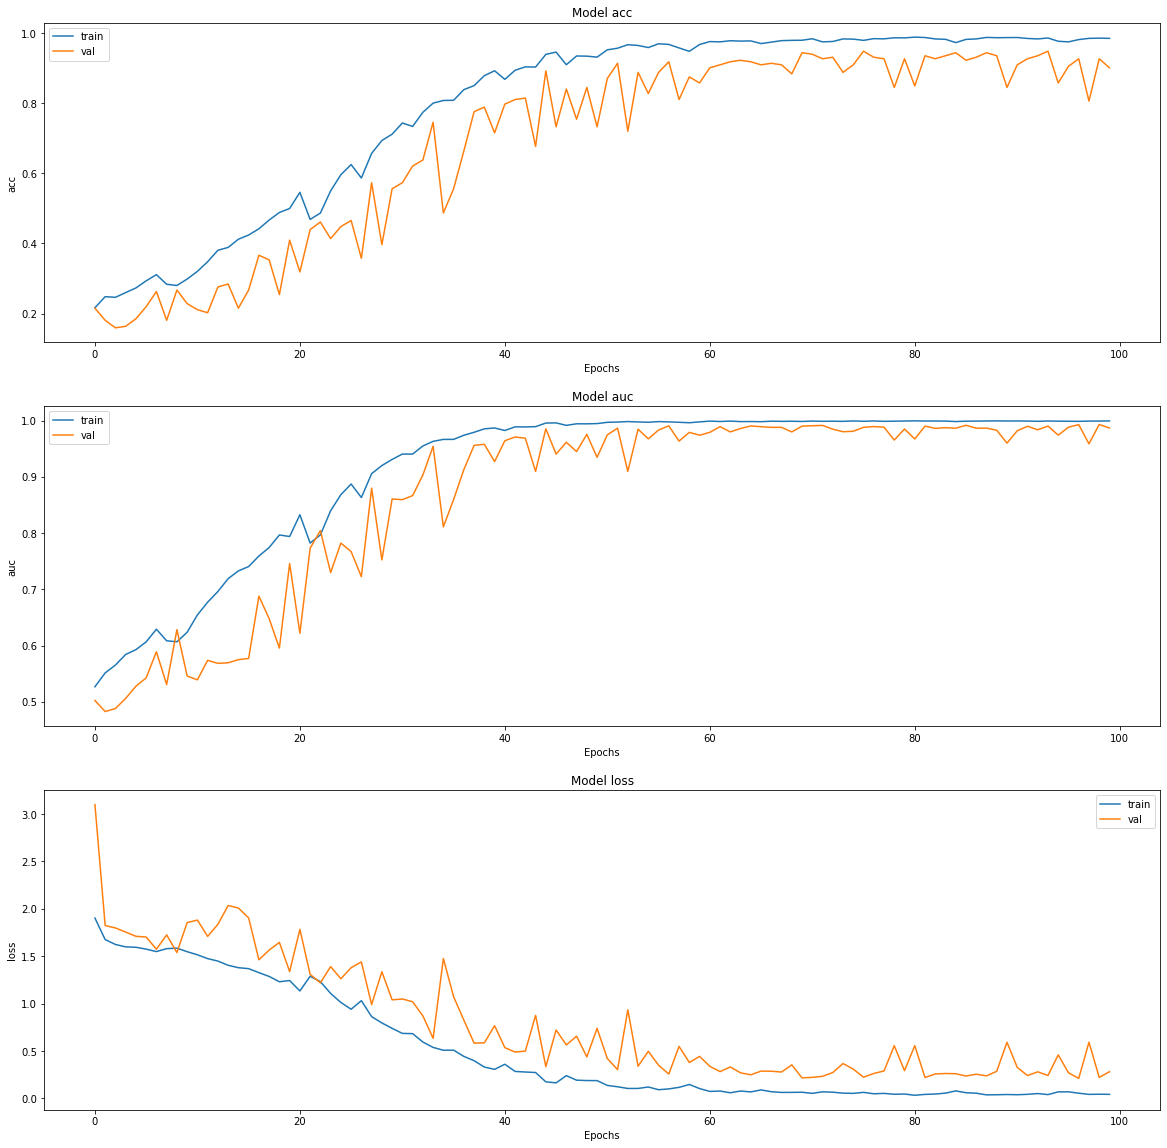

In [37]:
fig, ax = plt.subplots(3, 1, figsize = (20, 20))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_1[metric])
    ax[i].plot(history_1["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

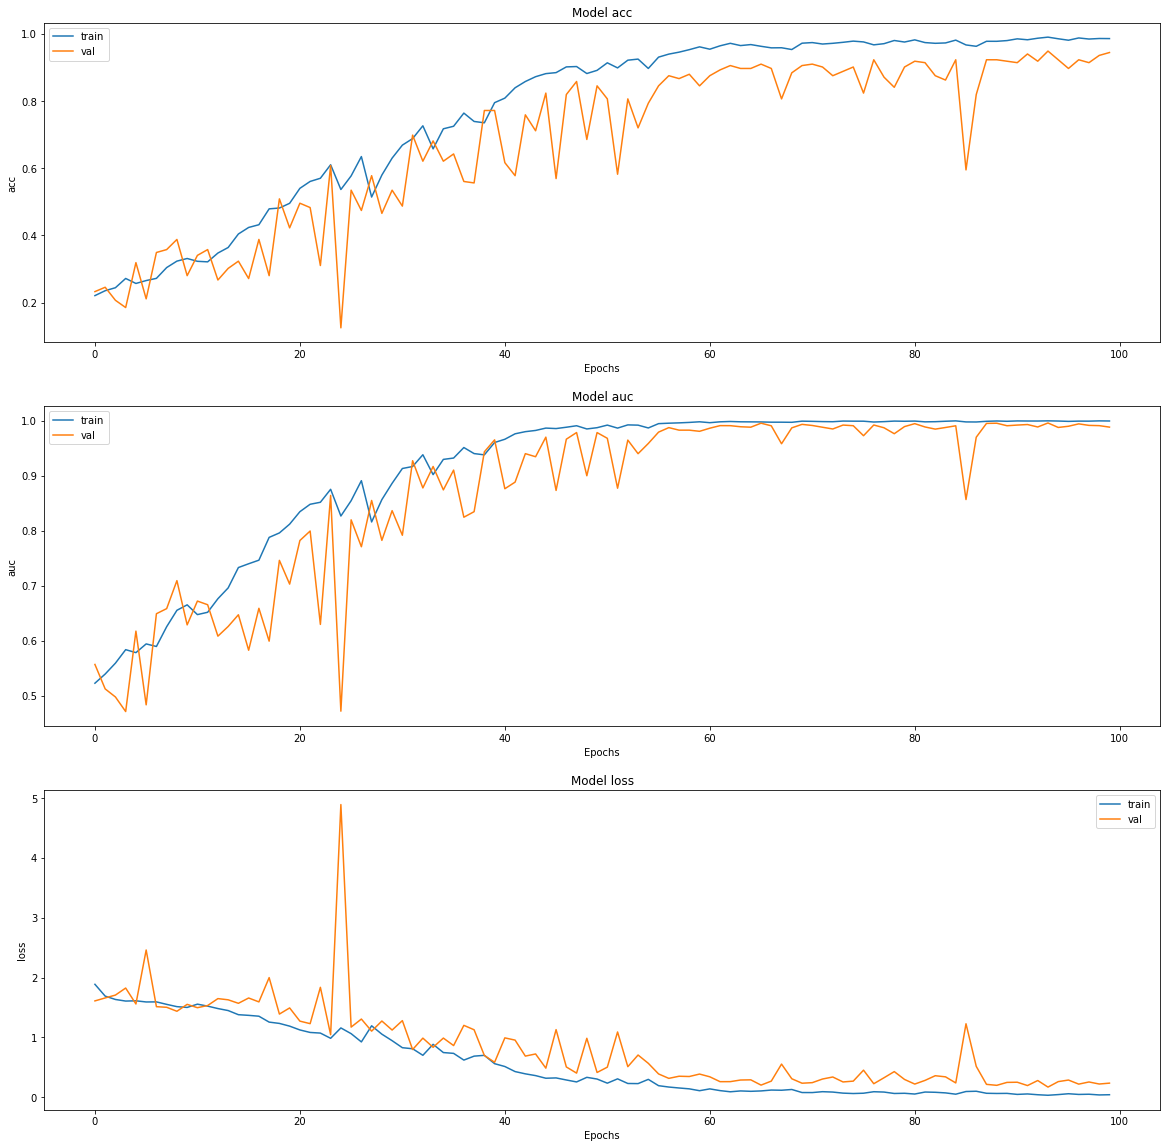

In [23]:
with open(save_dir + "history_2", 'rb') as file:
    history_2=pickle.load(file)
    
fig, ax = plt.subplots(3, 1, figsize = (20, 20))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_2[metric])
    ax[i].plot(history_2["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

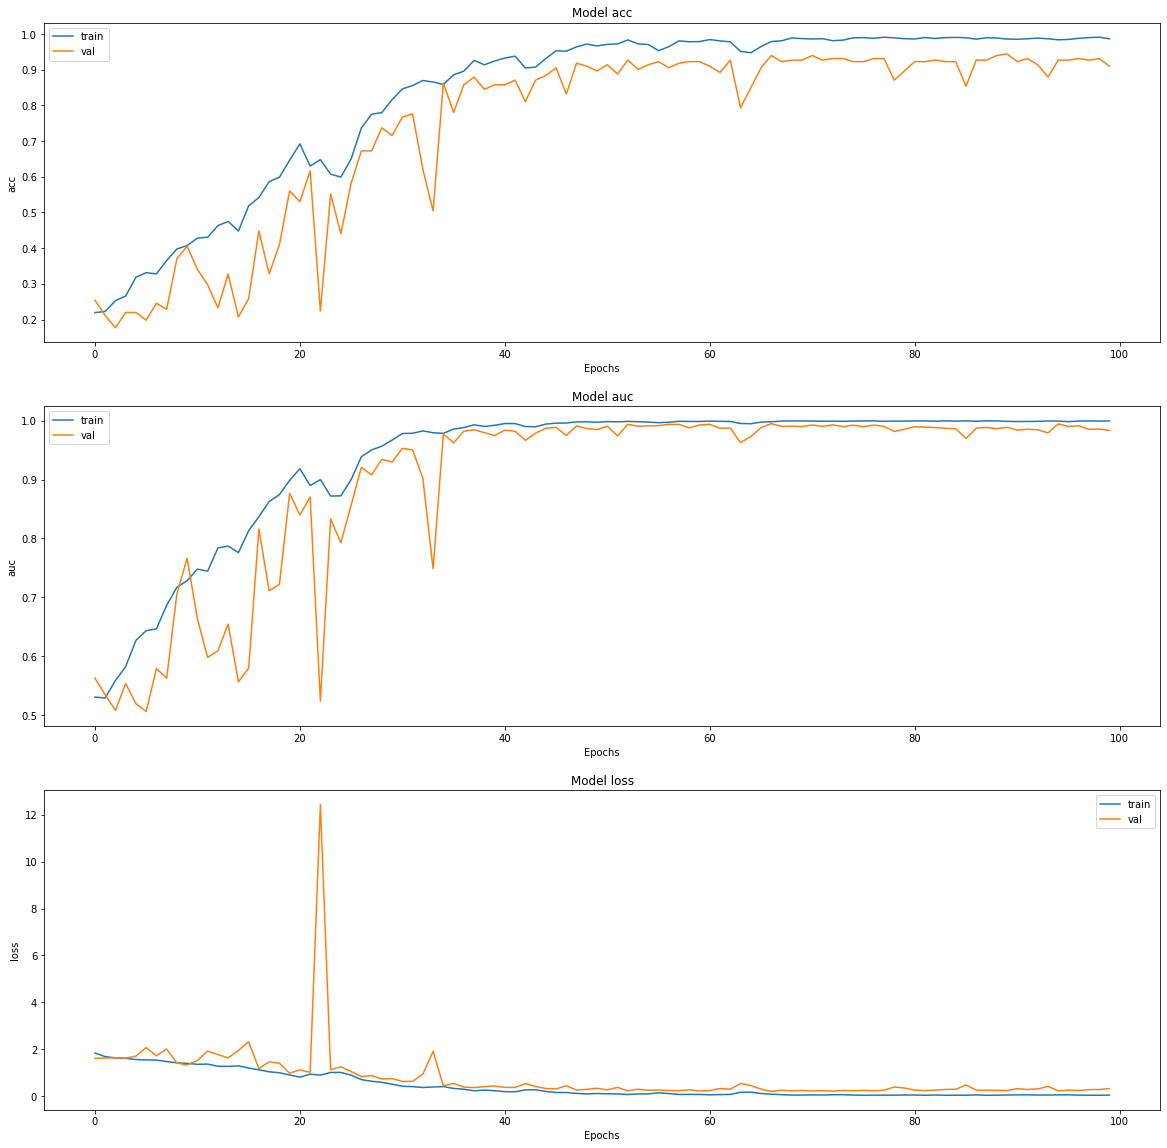

In [25]:
with open(save_dir + "history_3", 'rb') as file:
    history_3=pickle.load(file)
    
fig, ax = plt.subplots(3, 1, figsize = (20, 20))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_3[metric])
    ax[i].plot(history_3["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

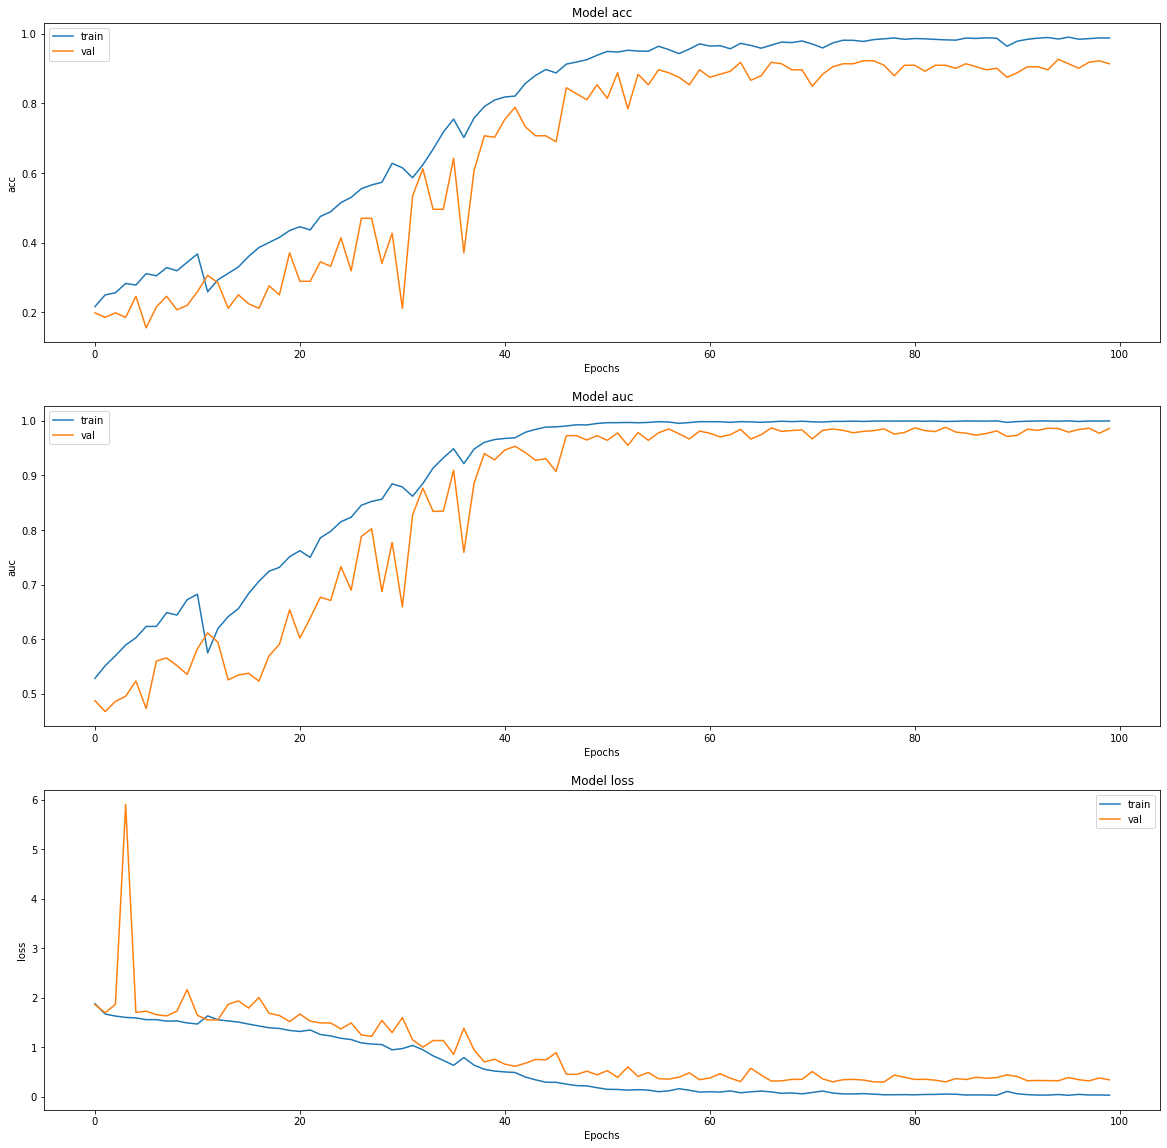

In [26]:
with open(save_dir + "history_4", 'rb') as file:
    history_4=pickle.load(file)
    
fig, ax = plt.subplots(3, 1, figsize = (20, 20))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_4[metric])
    ax[i].plot(history_4["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

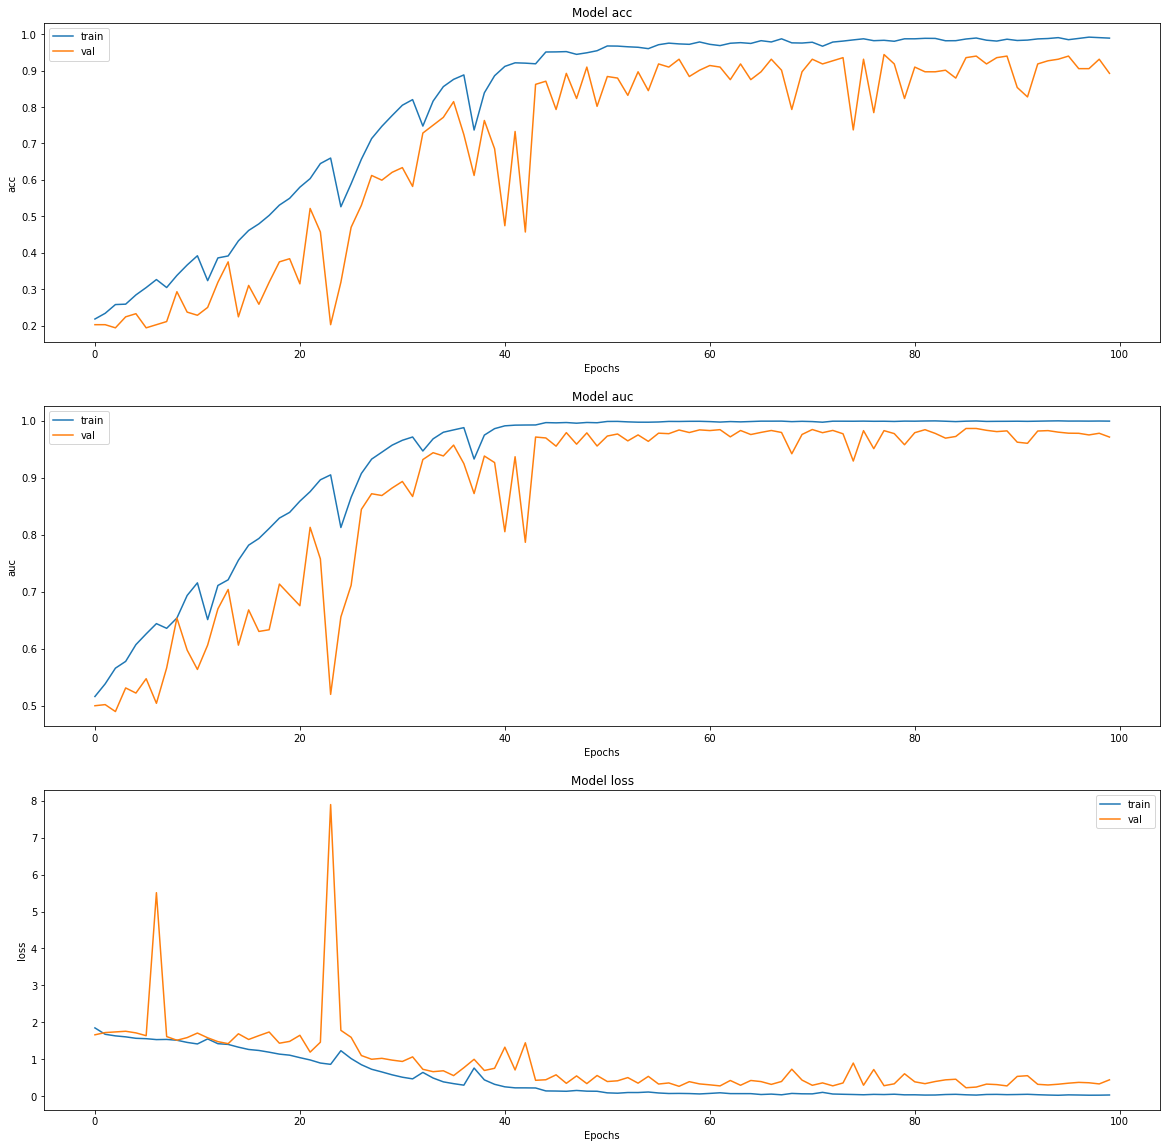

In [27]:
with open(save_dir + "history_5", 'rb') as file:
    history_5=pickle.load(file)
    
fig, ax = plt.subplots(3, 1, figsize = (20, 20))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_5[metric])
    ax[i].plot(history_5["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

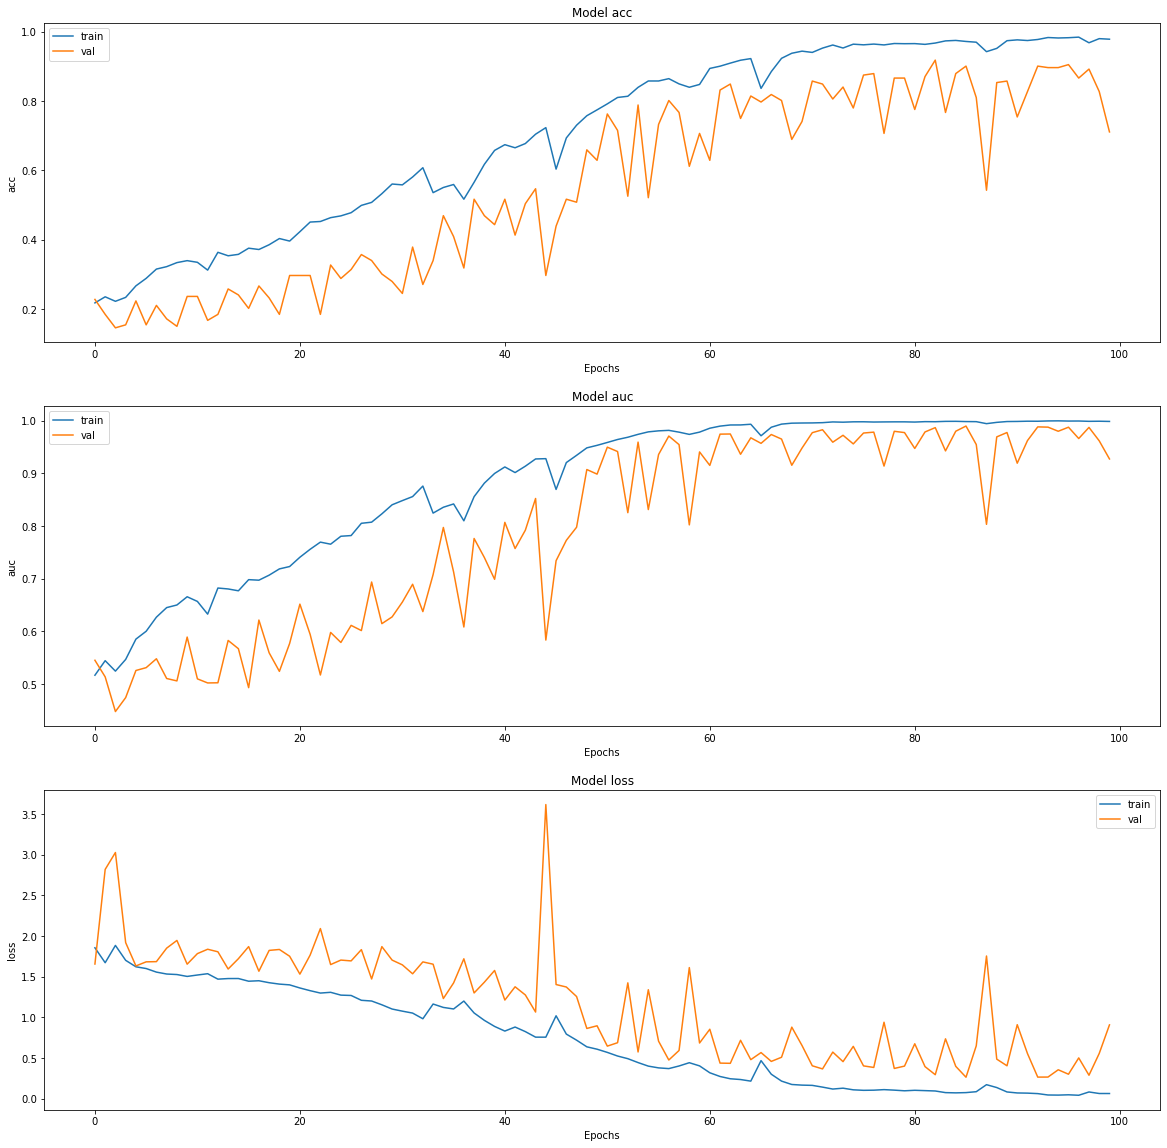

In [28]:
with open(save_dir + "history_10", 'rb') as file:
    history_10=pickle.load(file)
    
fig, ax = plt.subplots(3, 1, figsize = (20, 20))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_10[metric])
    ax[i].plot(history_10["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

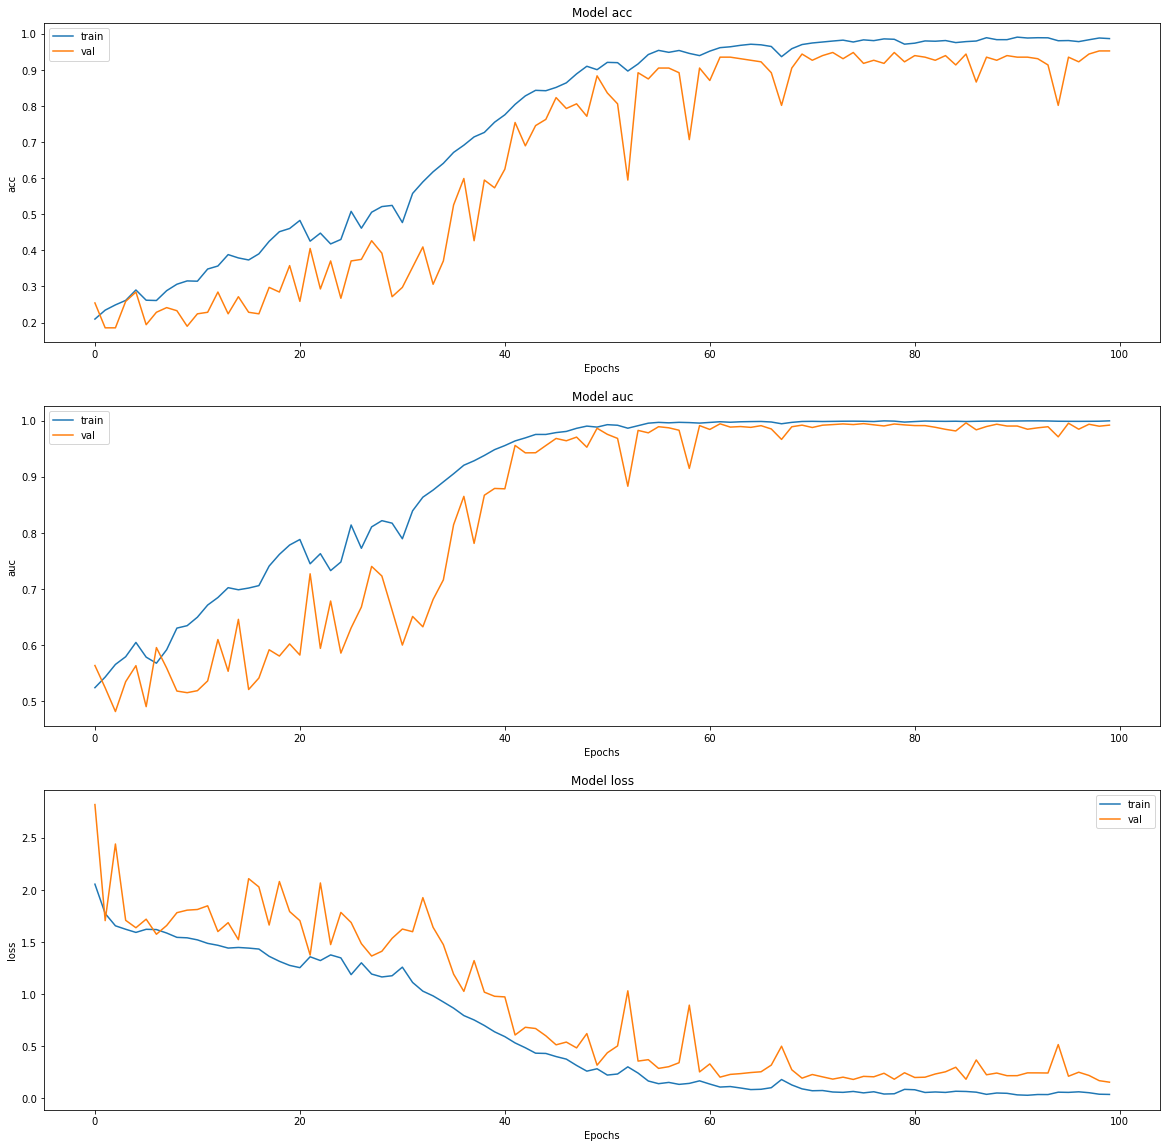

In [29]:
with open(save_dir + "history_15", 'rb') as file:
    history_15=pickle.load(file)
    
fig, ax = plt.subplots(3, 1, figsize = (20, 20))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_15[metric])
    ax[i].plot(history_15["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

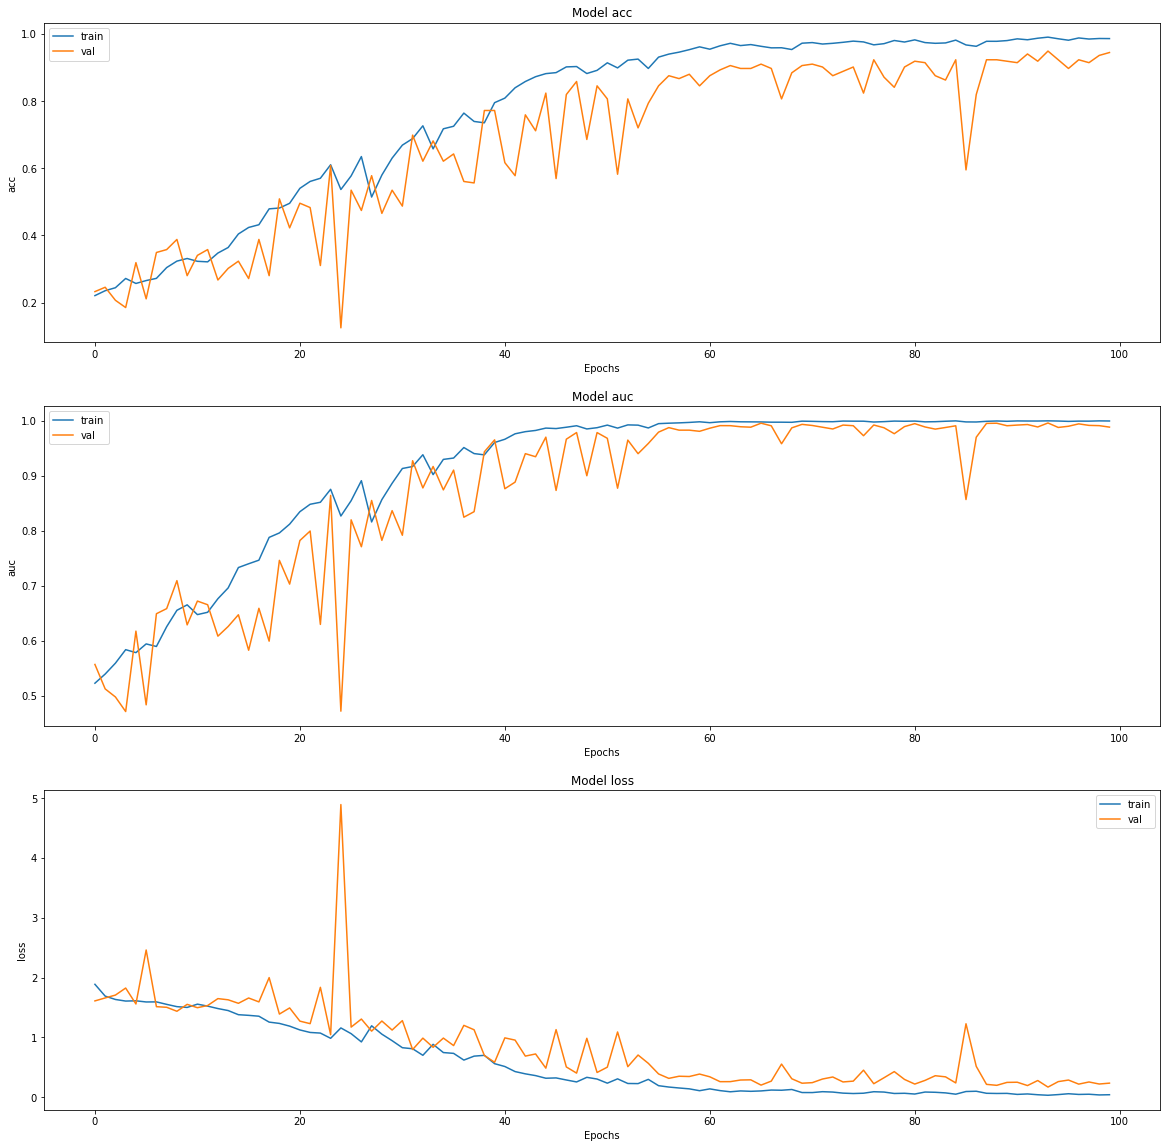

In [30]:
with open(save_dir + "history_2", 'rb') as file:
    history_20=pickle.load(file)
    
fig, ax = plt.subplots(3, 1, figsize = (20, 20))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_20[metric])
    ax[i].plot(history_20["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])